# Compare Temperature at 2m between ERA5 and GHCND.

In [147]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mpltcolors
import cmaps
from xhistogram.xarray import histogram
import geopandas as gpd
from matplotlib import cm
import functions_utils

In [148]:
import warnings
warnings.filterwarnings('ignore')

In [149]:
def trend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    return p

In [150]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [151]:
lon_min=190;lon_max=230
lat_min=55;lat_max=72

In [152]:
datadir = '/Projects/RAPrototype/GHCND/'

# READ STATIONS DATA

In [153]:
ifile=f'{datadir}/GHCND_Tmin_Tmax_Tavg_US_30yr.nc'
dso = xr.open_dataset(ifile)
dso = dso.sel(time=slice('1941-01-01','2024-12-31'))
dso = dso.where((dso['latitude']<=lat_max)&(dso['latitude']>=lat_min),drop=True)
dso['TMIN'] = dso['TMIN'].where(dso['TMIN']>-1000)
dso['TMIN'] = dso['TMIN']/10.* 9/5 + 32 # degreeF instead of 10th of degreeC
dso['TMAX'] = dso['TMAX'].where(dso['TMAX']>-1000)
dso['TMAX'] = dso['TMAX']/10.* 9/5 + 32 # degreeF instead of 10th of degreeC
Otmin = dso['TMIN']
Otmax = dso['TMAX']
units = f'$\degree$F'

# Get name of stations

In [154]:

Tstation=[]
for ip in range(0,len(dso['station'])):
  Tstation.append(dso['station'][ip].data.item())
ist = [ 0,2, 7,8,10,13,16,17,18,19,22,23,24,25,26,28,30,33,37,38,39,43,44,46,50,51,52,55,57,58,60,61,62,65,66,67,70]
for ii in range(0,len(ist)):
  Tstation.remove(dso['station'][ist[ii]].data.item())
ds = dso.sel(station=np.array(Tstation))


In [155]:
Tlabel=[]
for ip in range(0,len(ds['station'])):
  Tlabel.append(ds['station'][ip].data.item())

Text(0.5, 1.0, 'GHNCD stations - Alaska')

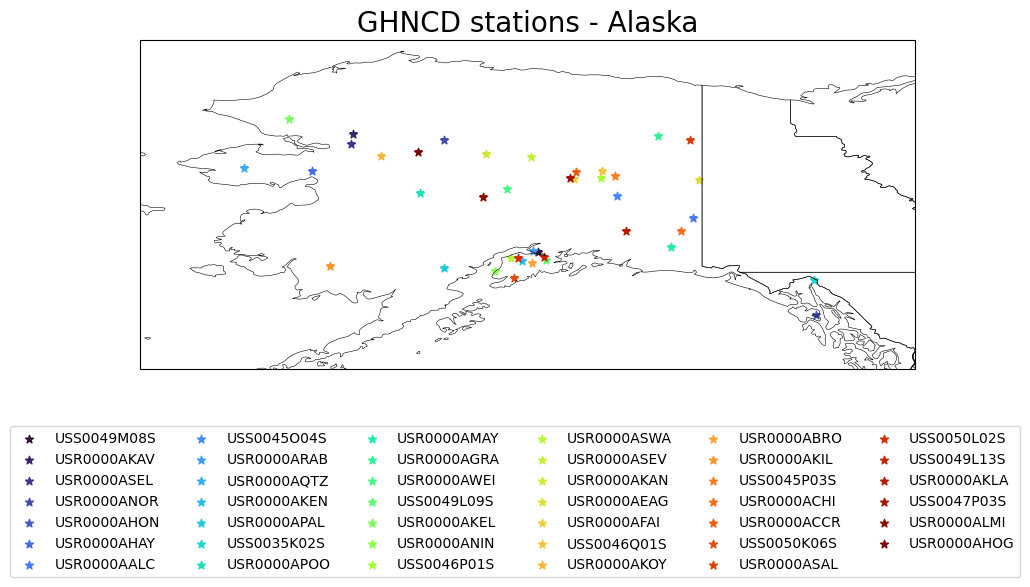

In [156]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(ds['station']))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  ax.scatter(ds['longitude'][ip],ds['latitude'][ip],marker='*',color=colors(ip),label=ds['station'][ip].data.item())

ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=6,bbox_to_anchor=(0.5,0.15),prop={'size': 10})
ax.set_title('GHNCD stations - Alaska',fontsize=20)

# READ ERA5 interpolated on GHCND 's stations.

In [157]:
dsEtmin=xr.open_dataset(f'{datadir}/era5_daily_tmin_GHCND_AK.nc')
dsEtmin = dsEtmin.sel(time=ds['time'],drop=True)
dsEtmax=xr.open_dataset(f'{datadir}/era5_daily_tmax_GHCND_AK.nc')
dsEtmax = dsEtmax.sel(time=ds['time'],drop=True)
Etmin = dsEtmin['Tmin']* 9/5 + 32 # degC to degF
Etmax = dsEtmax['Tmax']* 9/5 + 32 # degC to degF


# Time matching GHCND and ERA5

In [158]:
#obs = functions_utils.remove_outliers_seasons(ds['TAVG'],2)
Otmin = functions_utils.remove_outliers_seasons(ds['TMIN'],2)
Otmax = functions_utils.remove_outliers_seasons(ds['TMAX'],2)

In [159]:
masktmin = xr.where(np.isnan(Otmin)==False,1,0)
masktmax = xr.where(np.isnan(Otmax)==False,1,0)

In [160]:
Etmin = Etmin.where(masktmin==1)
Etmax = Etmax.where(masktmax==1)


In [161]:
Etmin['time'] = Otmin['time']
Etmin['station'] = Otmin['station']
Etmax['time'] = Otmin['time']
Etmax['station'] = Otmin['station']

# Compute Coldest Tmin & Warmest Tmax

In [162]:
yearb = 1941
yeare = 2024

In [163]:
Octmin = xr.zeros_like(Otmin.groupby('time.year').mean('time'))*np.NAN
Octmax = xr.zeros_like(Otmax.groupby('time.year').mean('time'))*np.NAN
Ectmin = xr.zeros_like(Etmin.groupby('time.year').mean('time'))*np.NAN
Ectmax = xr.zeros_like(Etmax.groupby('time.year').mean('time'))*np.NAN

for iyear in np.arange(yearb,yeare+1):
  ##
  Omin = Otmin.sel(time=slice(f'{iyear-1}-09-28',f'{iyear}-10-04')) #
  Omin = Omin.rolling(time=5,center=True).mean('time')
  Omin = Omin.sel(time=slice(f'{iyear-1}-10-01',f'{iyear}-09-30'))
  Octmin.loc[{'year':iyear}] = Omin.min('time')
  #
  Omax = Otmax.sel(time=slice(f'{iyear-1}-09-28',f'{iyear}-10-04')) #
  Omax = Omax.rolling(time=5,center=True).mean('time')
  Omax = Omax.sel(time=slice(f'{iyear-1}-10-01',f'{iyear}-09-30'))
  Octmax.loc[{'year':iyear}] = Omax.max('time')
  ##
  Emin = Etmin.sel(time=slice(f'{iyear-1}-09-28',f'{iyear}-10-04')) #
  Emin = Emin.rolling(time=5,center=True).mean('time')
  Emin = Emin.sel(time=slice(f'{iyear-1}-10-01',f'{iyear}-09-30'))
  Ectmin.loc[{'year':iyear}] = Emin.min('time')
  #
  Emax = Etmax.sel(time=slice(f'{iyear-1}-09-28',f'{iyear}-10-04')) #
  Emax = Emax.rolling(time=5,center=True).mean('time')
  Emax = Emax.sel(time=slice(f'{iyear-1}-10-01',f'{iyear}-09-30'))
  Ectmax.loc[{'year':iyear}] = Emax.max('time')


# Compute Trends 

In [164]:
Otrend_tmin = trend_dim(Octmin,'year')['polyfit_coefficients'].sel(degree=1)
Otrend_tmax = trend_dim(Octmax,'year')['polyfit_coefficients'].sel(degree=1)
Etrend_tmin = trend_dim(Ectmin,'year')['polyfit_coefficients'].sel(degree=1)
Etrend_tmax = trend_dim(Ectmax,'year')['polyfit_coefficients'].sel(degree=1)

# Table

In [165]:
rmse_OEmin = xr.zeros_like(Octmin.mean('year'))*np.nan 
corr_OEmin = xr.zeros_like(Octmin.mean('year'))*np.nan 
mbia_OEmin = xr.zeros_like(Octmin.mean('year'))*np.nan 

rmse_OEmax = xr.zeros_like(Octmax.mean('year'))*np.nan 
corr_OEmax = xr.zeros_like(Octmax.mean('year'))*np.nan 
mbia_OEmax = xr.zeros_like(Octmax.mean('year'))*np.nan 

## Compute RMSE

In [166]:
for ip in range(0,len(ds['station'])):
    rmse_OEmin[ip] = np.sqrt(np.nanmean((Otmin.isel(station=ip) - Etmin.isel(station=ip))**2))
    rmse_OEmax[ip] = np.sqrt(np.nanmean((Otmax.isel(station=ip) - Etmax.isel(station=ip))**2))  

## Compute Mean Bias

In [167]:
for ip in range(0,len(ds['station'])):
    mbia_OEmin[ip] = np.nanmean(Octmin.isel(station=ip)) - np.nanmean(Ectmin.isel(station=ip))
    mbia_OEmax[ip] = np.nanmean(Octmax.isel(station=ip)) - np.nanmean(Ectmax.isel(station=ip))

## Compute Correlation

In [168]:
for ip in range(0,len(ds['station'])):
    xxxmin = np.where(np.isnan(Octmin.isel(station=ip))==False)[0]
    xxxmax = np.where(np.isnan(Octmax.isel(station=ip))==False)[0]
    corr_OEmin[ip] = np.corrcoef(Octmin.isel(station=ip)[xxxmin],Ectmin.isel(station=ip)[xxxmin])[0][1]
    corr_OEmax[ip] = np.corrcoef(Octmax.isel(station=ip)[xxxmax],Ectmax.isel(station=ip)[xxxmax])[0][1]

In [169]:
dsout = rmse_OEmin.to_dataset(name='rmse_OEmin')
dsout = dsout.merge({'mbia_OEmin':mbia_OEmin, 'corr_OEmin':corr_OEmin})
dsout = dsout.merge({'Otrend_tmin':Otrend_tmin})
dsout = dsout.merge({'Etrend_tmin':Etrend_tmin})
dsout = dsout.merge({'rmse_OEmax':rmse_OEmax, 'mbia_OEmax':mbia_OEmax,'corr_OEmax':corr_OEmax})
dsout = dsout.merge({'Otrend_tmax':Otrend_tmax})
dsout = dsout.merge({'Etrend_tmax':Etrend_tmax})


In [170]:
dsout['station']=Tlabel
dsout = dsout.drop('degree')
df = dsout.to_dataframe()
df = df.transpose()

In [171]:
df['diagnostic'] = ['rmse (\u00B0F)','bias (\u00B0F)','correlation',\
                    'trend (\u00B0F/year)','trend (\u00B0F/year)',\
                    'rmse (\u00B0F)','bias (\u00B0F)','correlation',\
                    'trend (\u00B0F/year)','trend (\u00B0F/year)']
df['model'] = ['Obs/ERA5','Obs/ERA5','Obs/ERA5','Obs','ERA5',\
               'Obs/ERA5','Obs/ERA5','Obs/ERA5','Obs','ERA5']
df['variable'] = ['Coldest Tmin','Coldest Tmin','Coldest Tmin','Coldest Tmin','Coldest Tmin',
                  'Warmest Tmax','Warmest Tmax','Warmest Tmax','Warmest Tmax','Warmest Tmax']

In [172]:
table = pd.pivot_table(df,  index=['variable', 'diagnostic','model'])
table_style = table.style
styled_table = table_style.format('{:.2f}')
styled_table

In [173]:
print(rmse_OEmin.min().data.item(),rmse_OEmin.max().data.item())
print(rmse_OEmax.min().data.item(),rmse_OEmax.max().data.item())

4.3665202842927116 13.744492925475484
6.037358617530248 15.3288534047902


In [174]:
Tipl=['USR0000ACCR','USR0000AEAG','USR0000AFAI','USR0000AKIL','USR0000AKLA','USS0045P03S','USS0046P01S']

Text(0.5, 0.98, 'RMSE GHNCD vs ERA5, Coldest Tmin of the year')

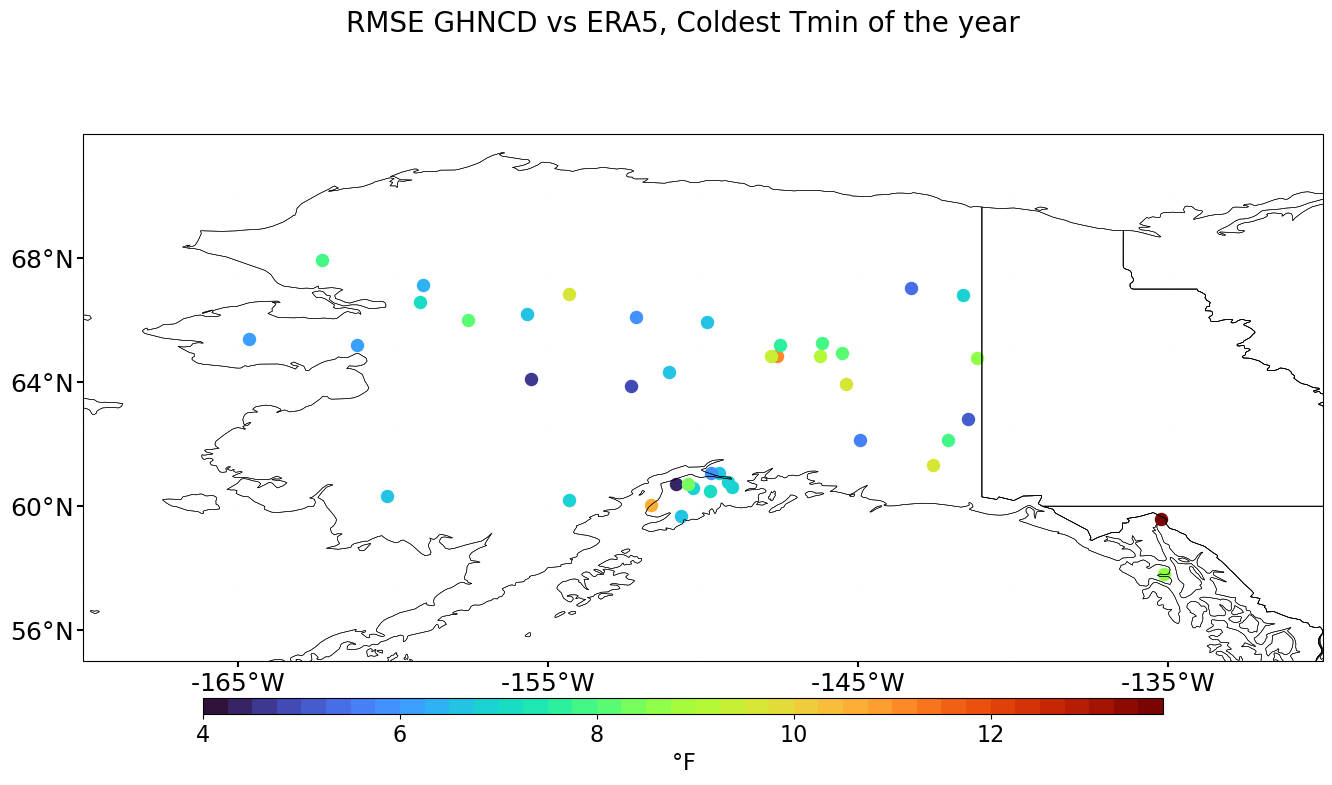

In [175]:
proj=ccrs.PlateCarree()
clevs=np.arange(4,14,0.25)
cmap=cm.get_cmap('turbo',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=rmse_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs ERA5, Coldest Tmin of the year',fontsize=20)

Text(0.5, 0.98, 'RMSE GHNCD vs ERA5, Warmest Tmax of the year')

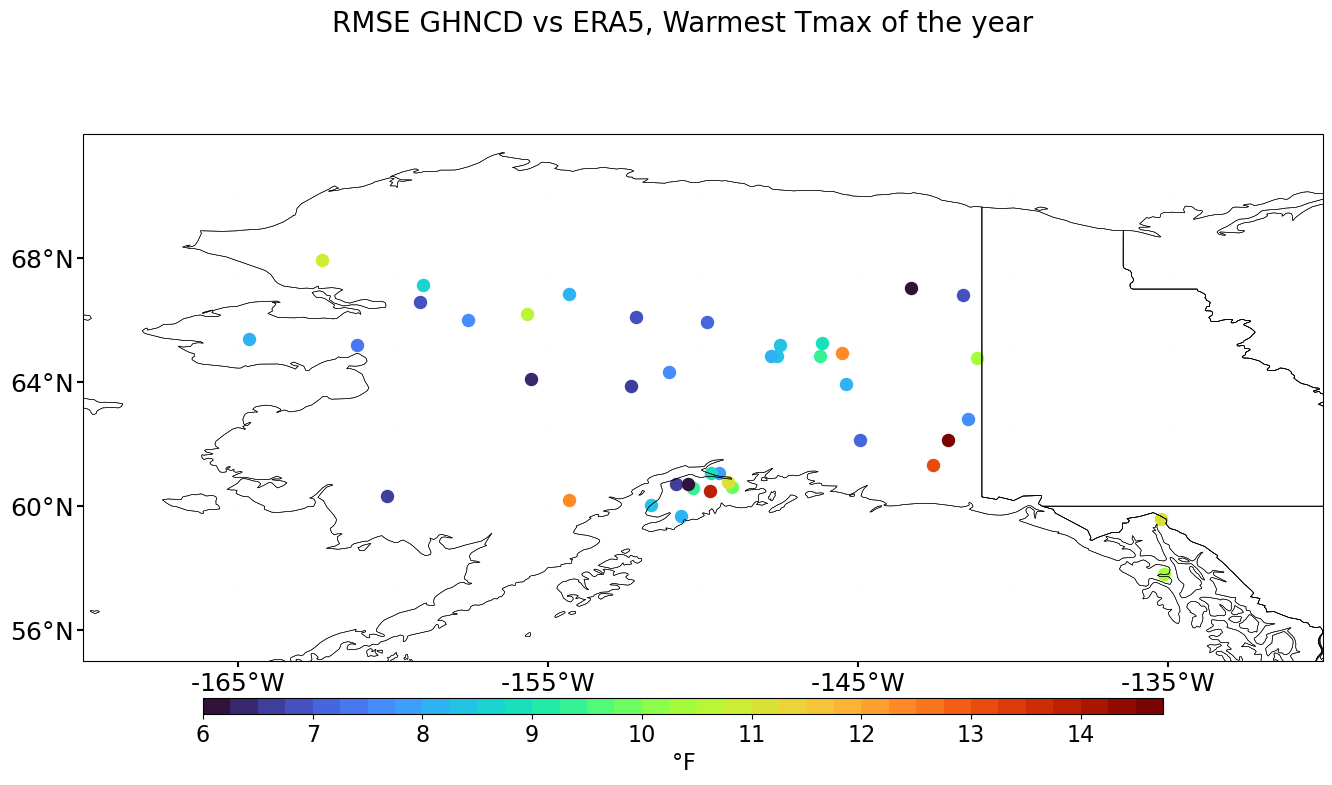

In [176]:
proj=ccrs.PlateCarree()
clevs=np.arange(6,15,0.25)
cmap=cm.get_cmap('turbo',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=rmse_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('RMSE GHNCD vs ERA5, Warmest Tmax of the year',fontsize=20)

In [177]:
print(mbia_OEmin.min().data.item(),mbia_OEmin.max().data.item())
print(mbia_OEmax.min().data.item(),mbia_OEmax.max().data.item())

-30.3602266204834 11.014339388760654
0.22960497492010745 20.248284851074217


Text(0.5, 0.98, 'Mean Bias GHNCD vs ERA5, Coldest Tmin of the year')

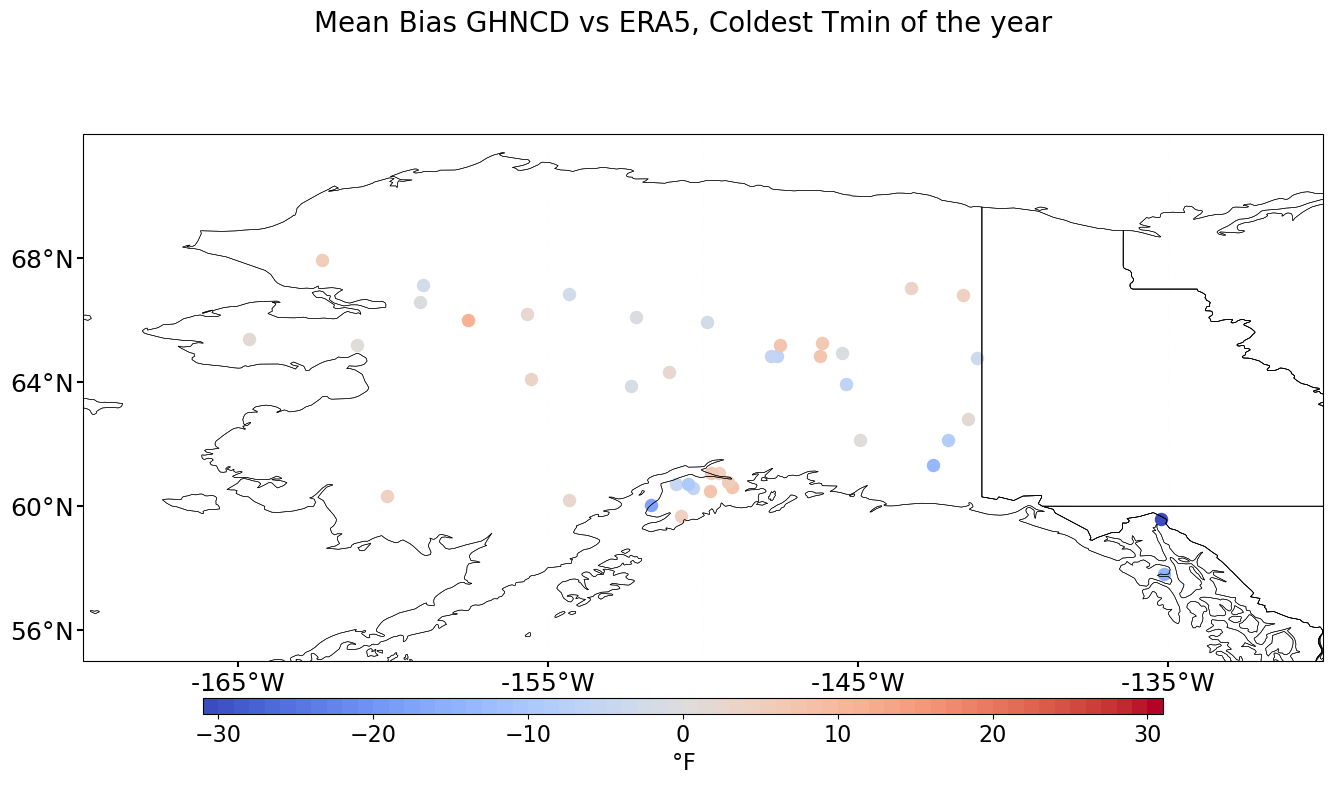

In [178]:
proj=ccrs.PlateCarree()
clevs=np.arange(-31,32,1)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=mbia_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Mean Bias GHNCD vs ERA5, Coldest Tmin of the year',fontsize=20)

Text(0.5, 0.98, 'Mean Bias GHNCD vs ERA5, Warmest Tmax of the year')

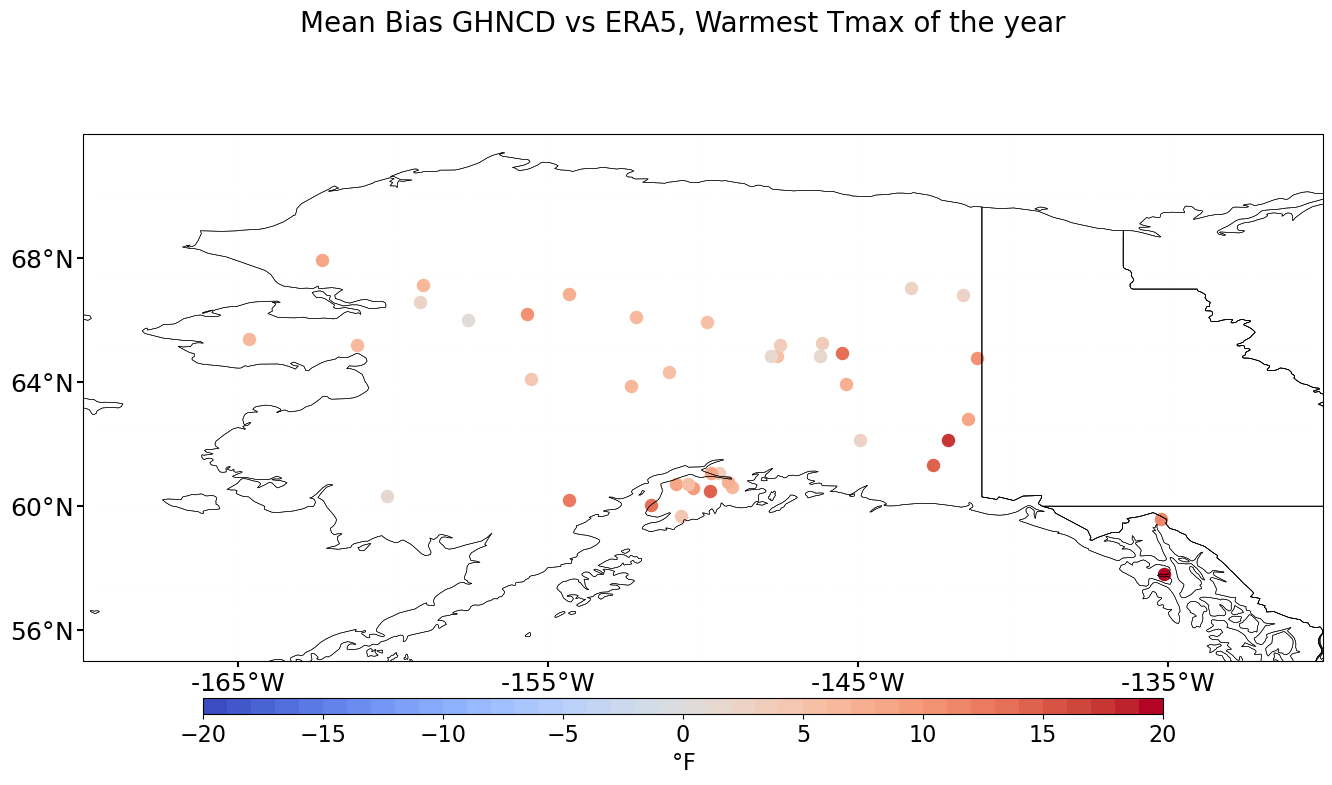

In [179]:
proj=ccrs.PlateCarree()
clevs=np.arange(-20,21,1)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=mbia_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Mean Bias GHNCD vs ERA5, Warmest Tmax of the year',fontsize=20)

In [180]:
print(corr_OEmin.min().data.item(),corr_OEmin.max().data.item())
print(corr_OEmax.min().data.item(),corr_OEmax.max().data.item())

0.6200610486168933 0.9964789890652999
0.1929179414738652 0.9779694674741184


Text(0.5, 0.98, 'Correlation GHNCD vs ERA5, Coldest Tmin of the year')

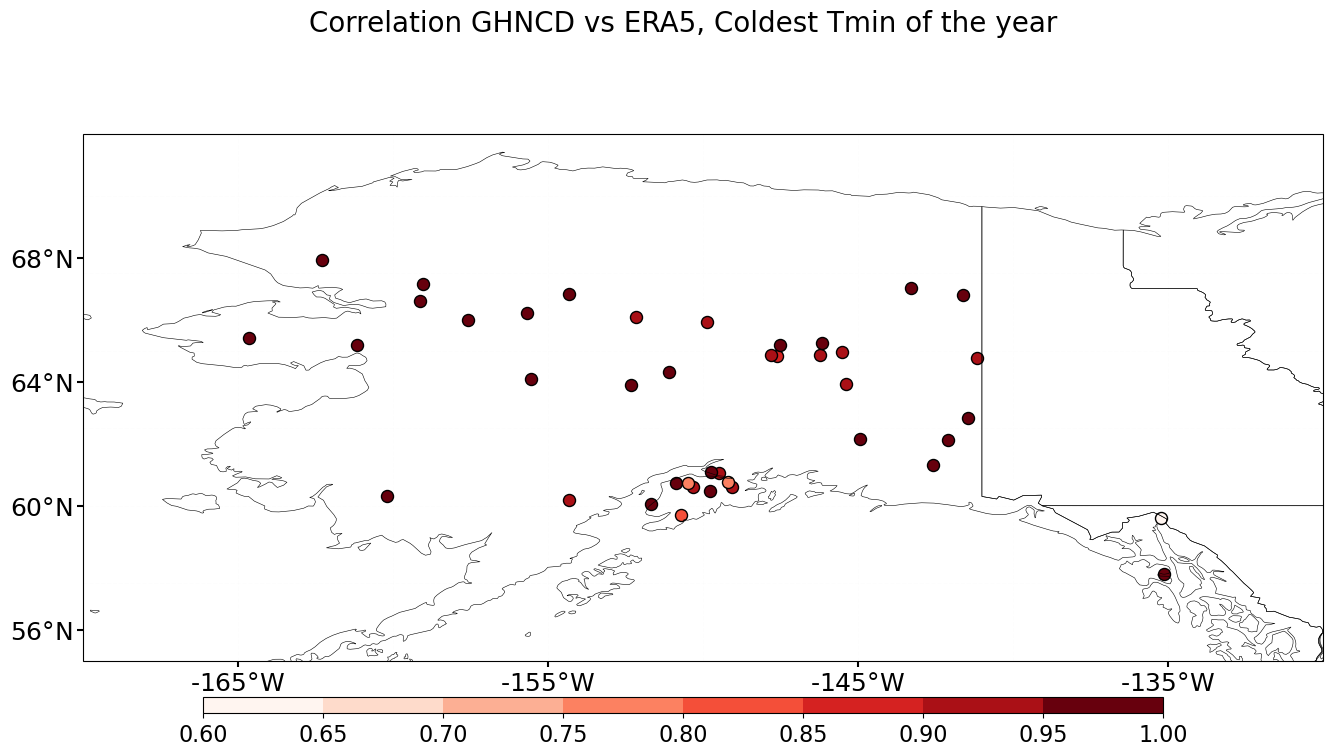

In [181]:
proj=ccrs.PlateCarree()
clevs=np.arange(0.6,1.05,0.05)
cmap=cm.get_cmap('Reds',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=corr_OEmin[ip],vmin=clevs[0],vmax=clevs[-1],edgecolor='k',marker='o',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs)
cbar.set_label(label='',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Correlation GHNCD vs ERA5, Coldest Tmin of the year',fontsize=20)

Text(0.5, 0.98, 'Correlation GHNCD vs ERA5, Warmest Tmax of the year')

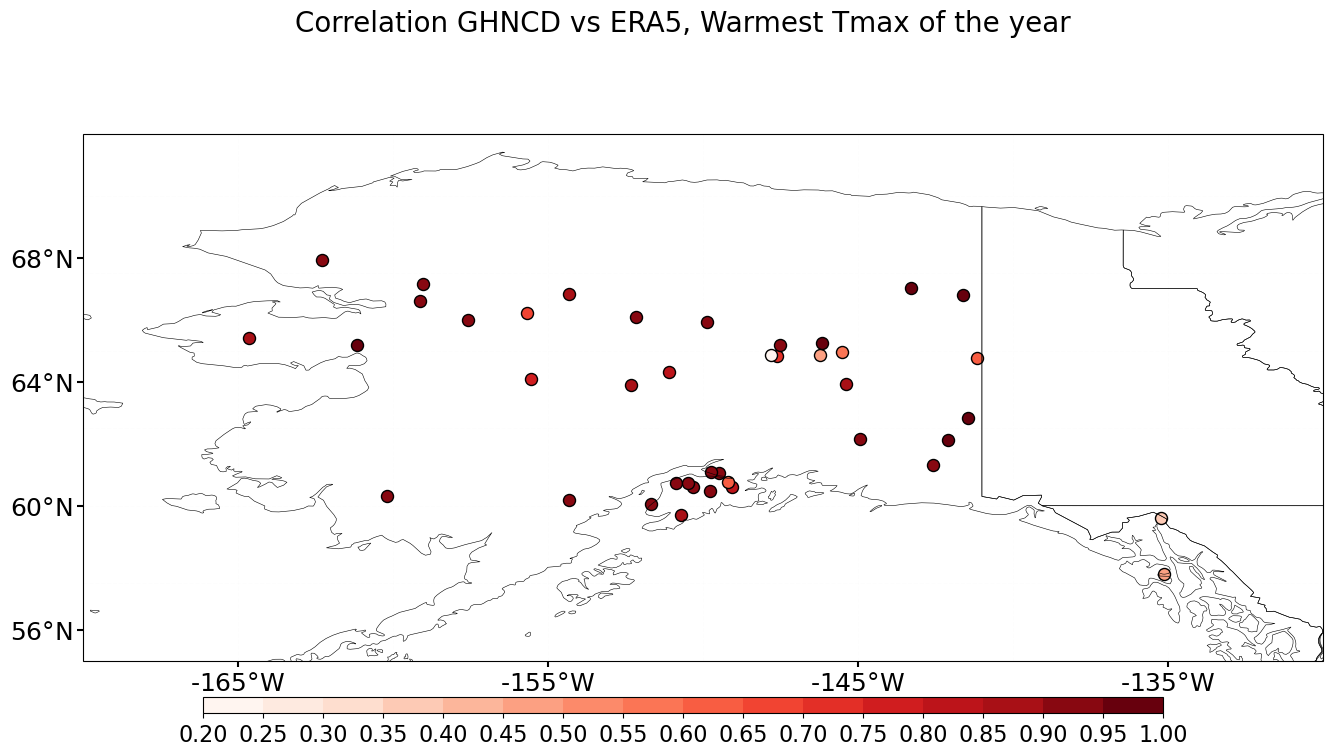

In [182]:
proj=ccrs.PlateCarree()
clevs=np.arange(0.2,1.05,0.05)
cmap=cm.get_cmap('Reds',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=corr_OEmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',edgecolor='k',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs)
cbar.set_label(label='',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Correlation GHNCD vs ERA5, Warmest Tmax of the year',fontsize=20)

In [183]:
print(Otrend_tmin.min().data.item(),Otrend_tmin.max().data.item())
print(Etrend_tmax.min().data.item(),Etrend_tmax.max().data.item())

-1.3537015635621907 0.30693316048858305
-0.2199915245892505 0.26673736546765403


Text(0.5, 0.98, 'Trends Coldest Tmin of the year, GHCND (O) & ERA5 (♢)')

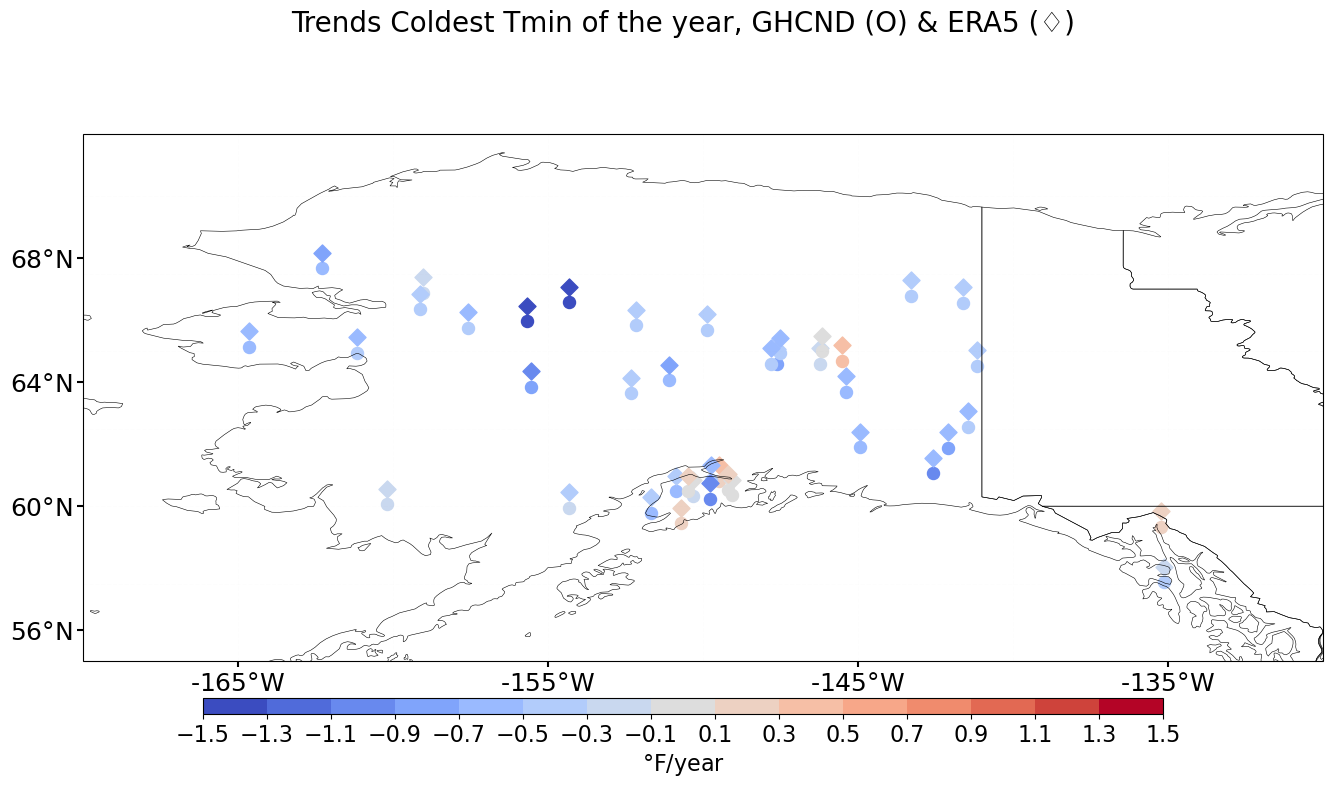

In [184]:
proj=ccrs.PlateCarree()
clevs=np.arange(-1.5,1.7,0.2)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.25,c=Otrend_tmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.25,c=Etrend_tmin[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs)
cbar.set_label(label=f'{units}/year',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Trends Coldest Tmin of the year, GHCND (O) & ERA5 (\u2662)',fontsize=20)

Text(0.5, 0.98, 'Trends Coldest Tmin of the year, GHCND - ERA5')

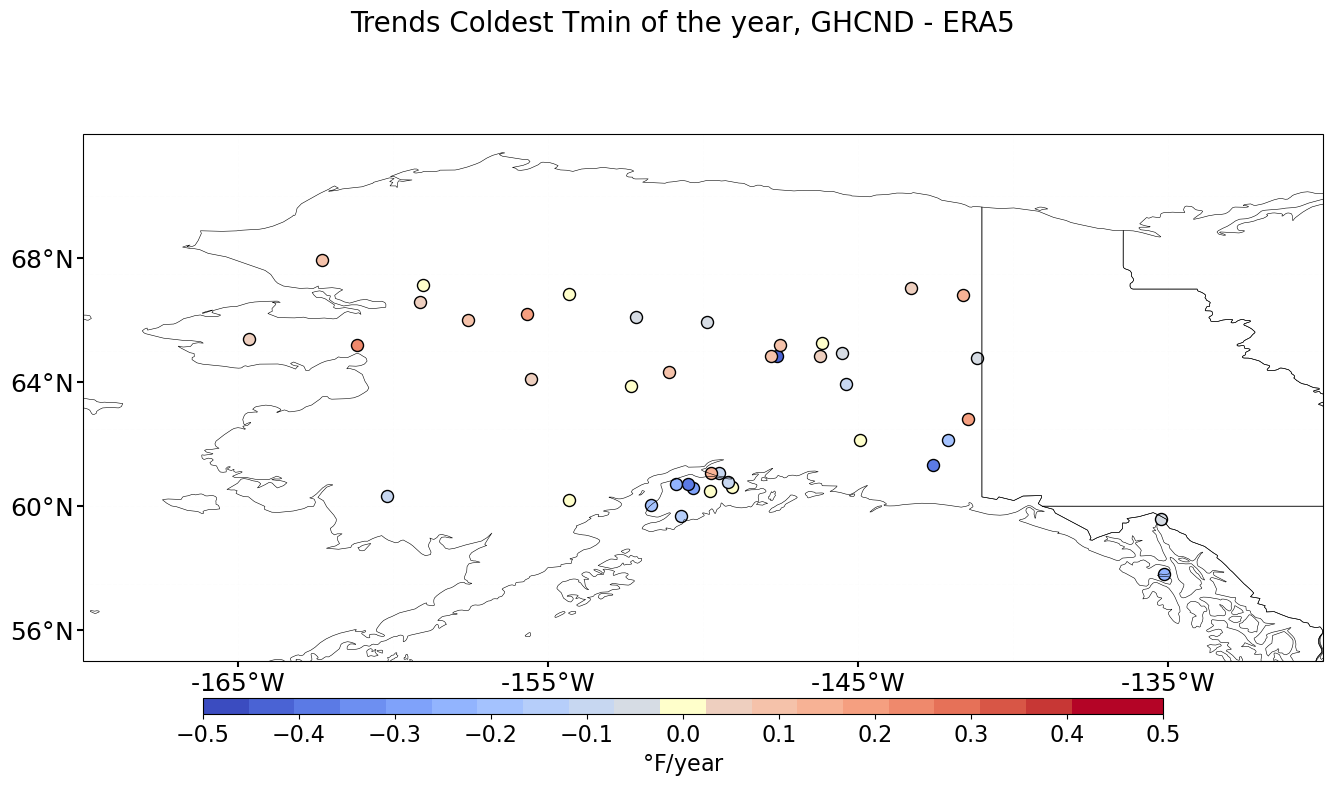

In [194]:
proj=ccrs.PlateCarree()
clevs=np.arange(-0.5,0.55,0.05)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)
n = len(clevs)
cmaplist = [cmap(i) for i in range(0,n)]
cmaplist[n // 2] = '#FFFFCB' #[0.8, 0.8, 0.8, 1]
my_cmap = mpltcolors.LinearSegmentedColormap.from_list('Custom cmap',cmaplist, len(cmaplist))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  dd = Otrend_tmin[ip]-Etrend_tmin[ip]
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=dd,vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=my_cmap,edgecolor='k',s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs[::2])
cbar.set_label(label=f'{units}/year',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Trends Coldest Tmin of the year, GHCND - ERA5',fontsize=20)

Text(0.5, 0.98, 'Trends Warmest Tmax of the year, GHCND (O) & ERA5 (♢)')

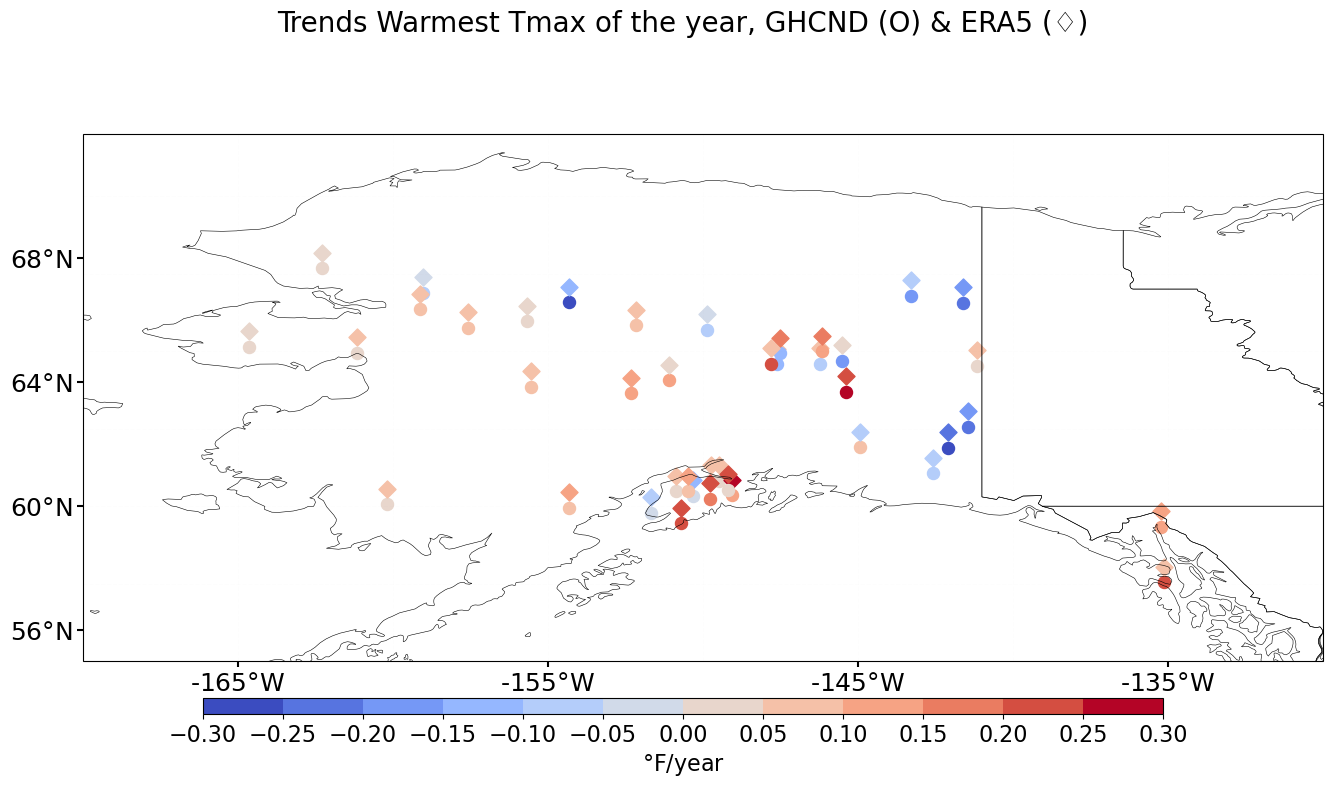

In [186]:
proj=ccrs.PlateCarree()
clevs=np.arange(-0.3,0.35,0.05)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]-0.25,c=Otrend_tmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='o',cmap=cmap,s=75)
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip]+0.25,c=Etrend_tmax[ip],vmin=clevs[0],vmax=clevs[-1],marker='D',cmap=cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs)
cbar.set_label(label=f'{units}/year',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Trends Warmest Tmax of the year, GHCND (O) & ERA5 (\u2662)',fontsize=20)

Text(0.5, 0.98, 'Trends Warmest Tmax of the year, GHCND - ERA5')

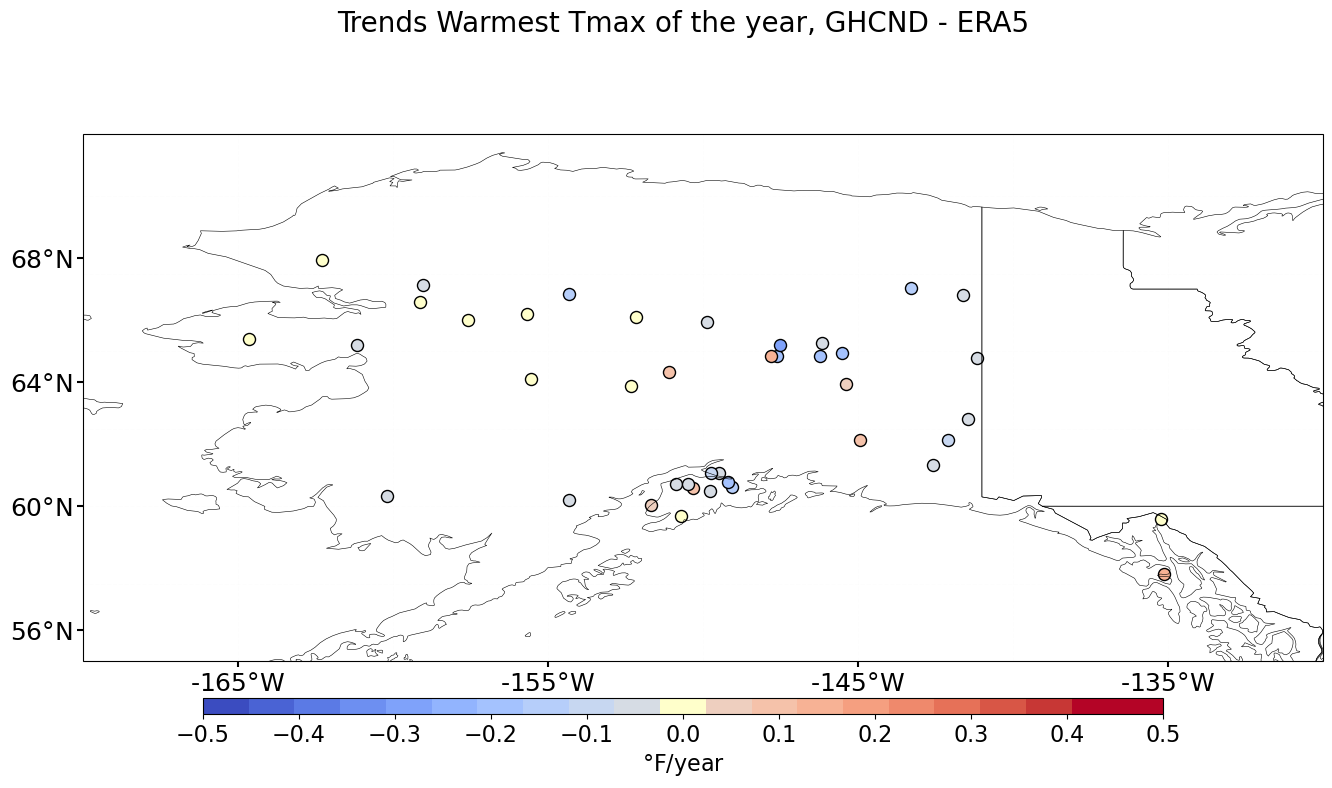

In [ ]:
proj=ccrs.PlateCarree()
clevs=np.arange(-0.5,0.55,0.05)
cmap=cm.get_cmap('coolwarm',len(clevs)-1)

n = len(clevs)
cmaplist = [cmap(i) for i in range(0,n)]
cmaplist[n // 2] = '#FFFFCB' #[0.8, 0.8, 0.8, 1]
my_cmap = mpltcolors.LinearSegmentedColormap.from_list('Custom cmap',cmaplist, len(cmaplist))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  dd = Otrend_tmax[ip]-Etrend_tmax[ip]
  cc=ax.scatter(ds['longitude'][ip],ds['latitude'][ip],c=dd,vmin=clevs[0],vmax=clevs[-1],marker='o',edgecolor='k',cmap=my_cmap,s=75)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc, cax=cbar_ax,orientation='horizontal',label='',ticks=clevs[::2])
cbar.set_label(label=f'{units}/year',fontsize=16)
cbar.ax.tick_params(labelsize=16)
ax.set_extent([190,230,55,72],proj)
grd = ax.gridlines(
draw_labels=False, 
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx)}$\degree$W' for ixx in ax.get_xticks()],size=18)
plt.suptitle('Trends Warmest Tmax of the year, GHCND - ERA5',fontsize=20)

In [140]:
Otrend_tmin = trend_dim(Octmin,'year')
Otrend_tmax = trend_dim(Octmax,'year')
Etrend_tmin = trend_dim(Ectmin,'year')
Etrend_tmax = trend_dim(Ectmax,'year')

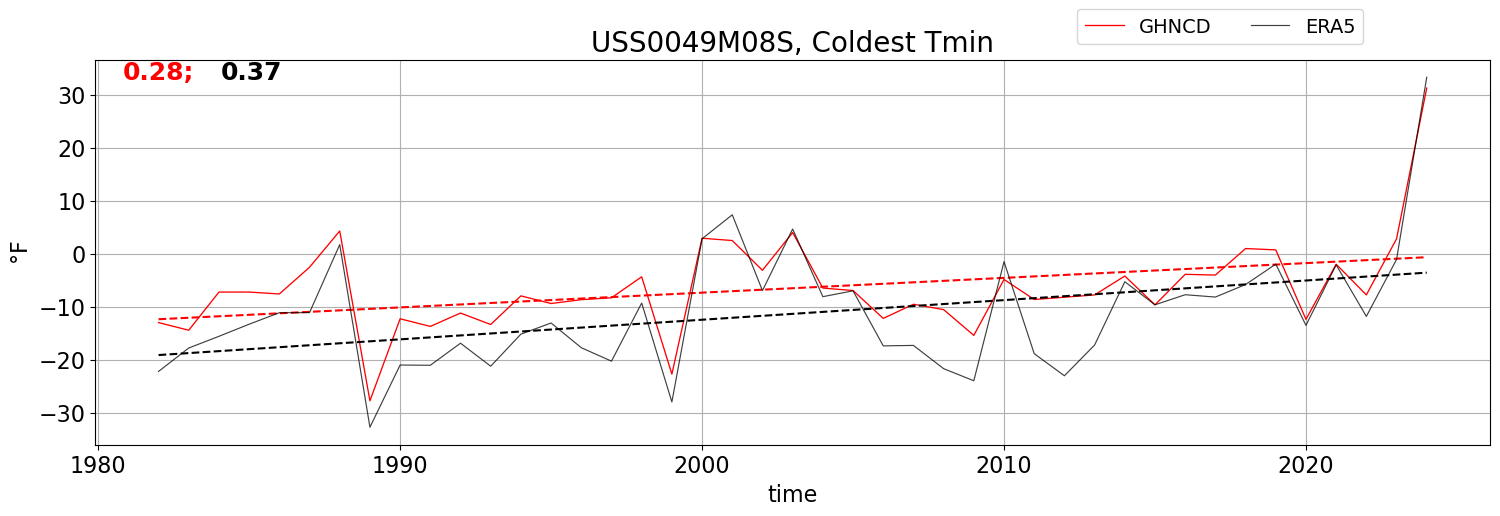

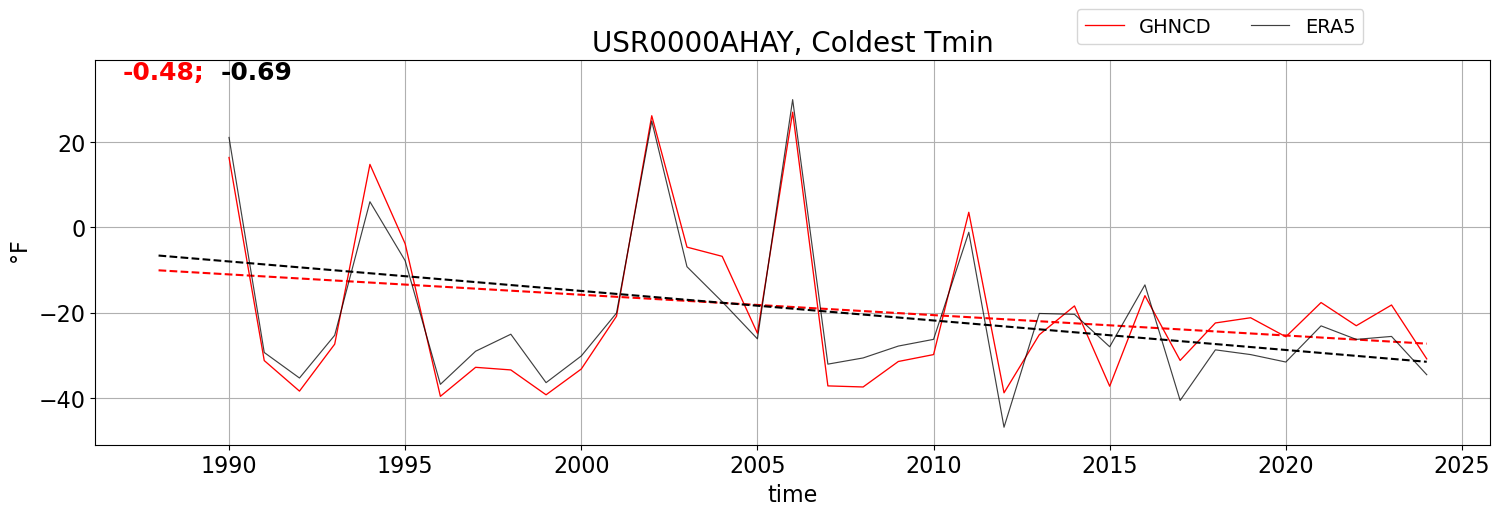

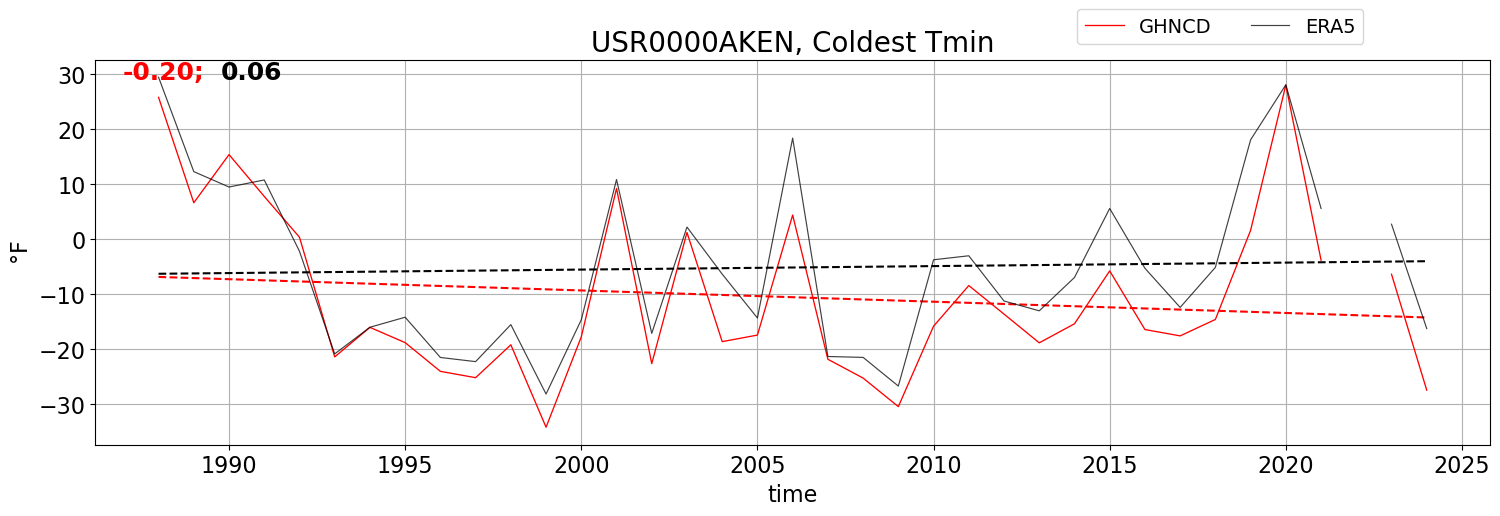

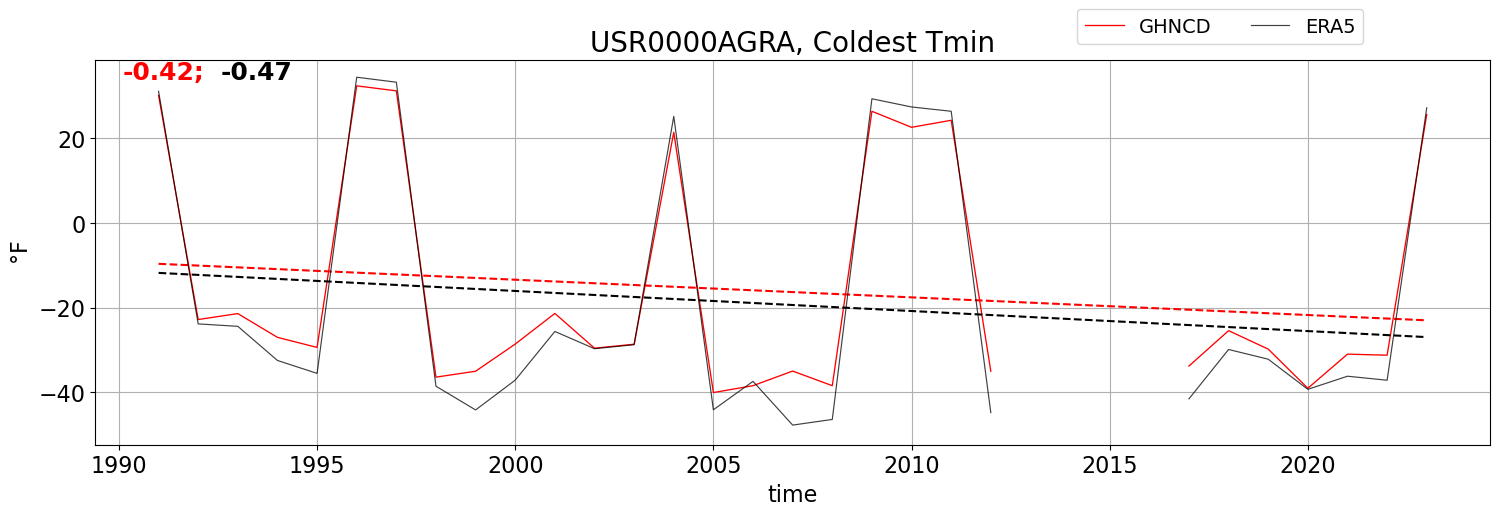

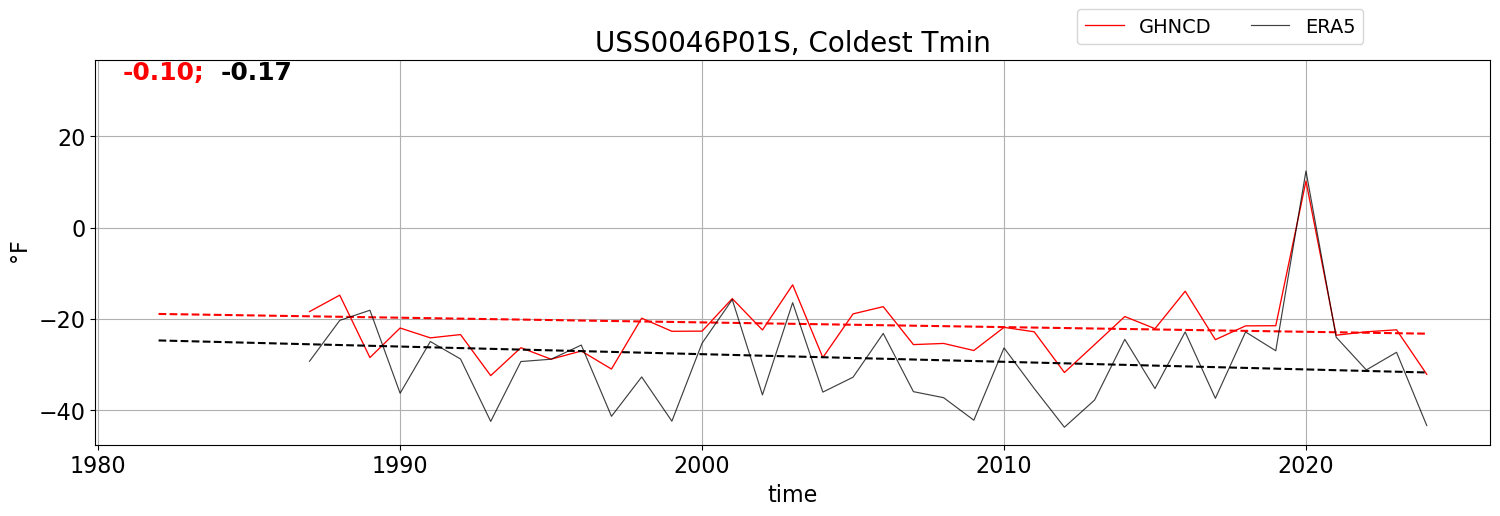

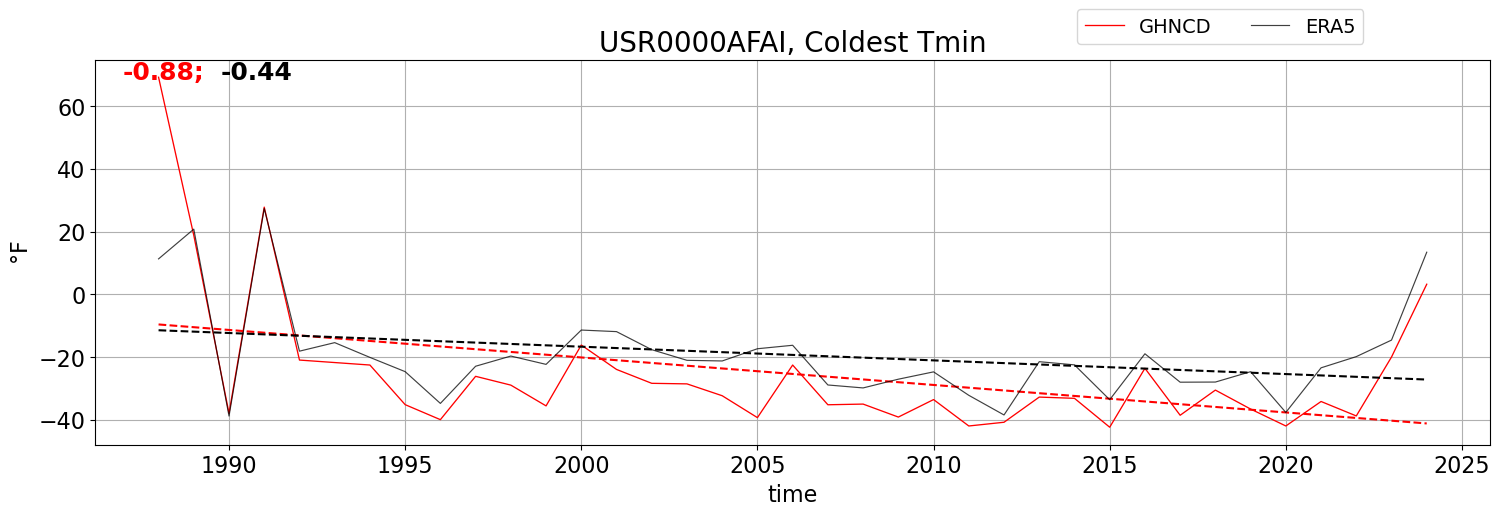

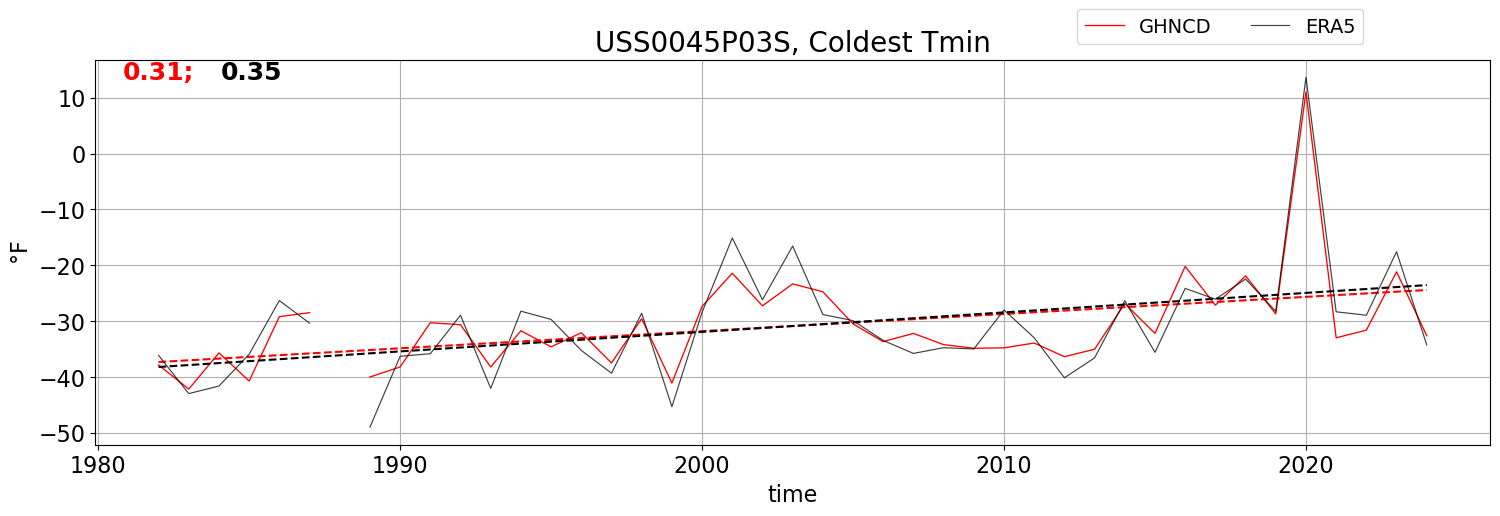

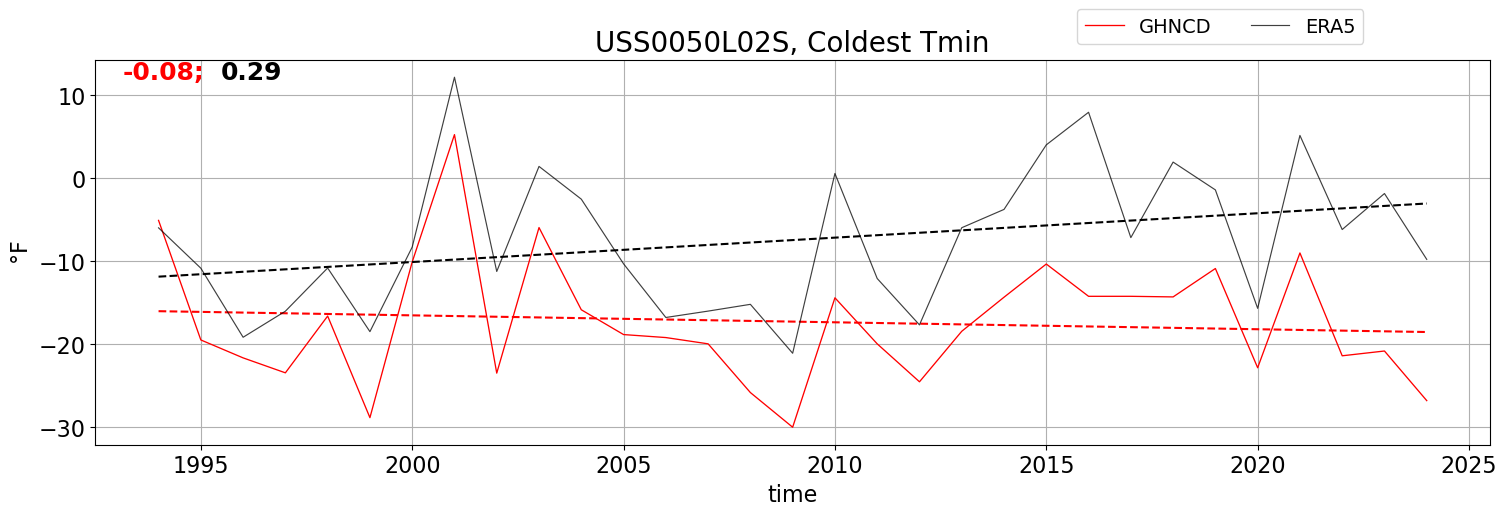

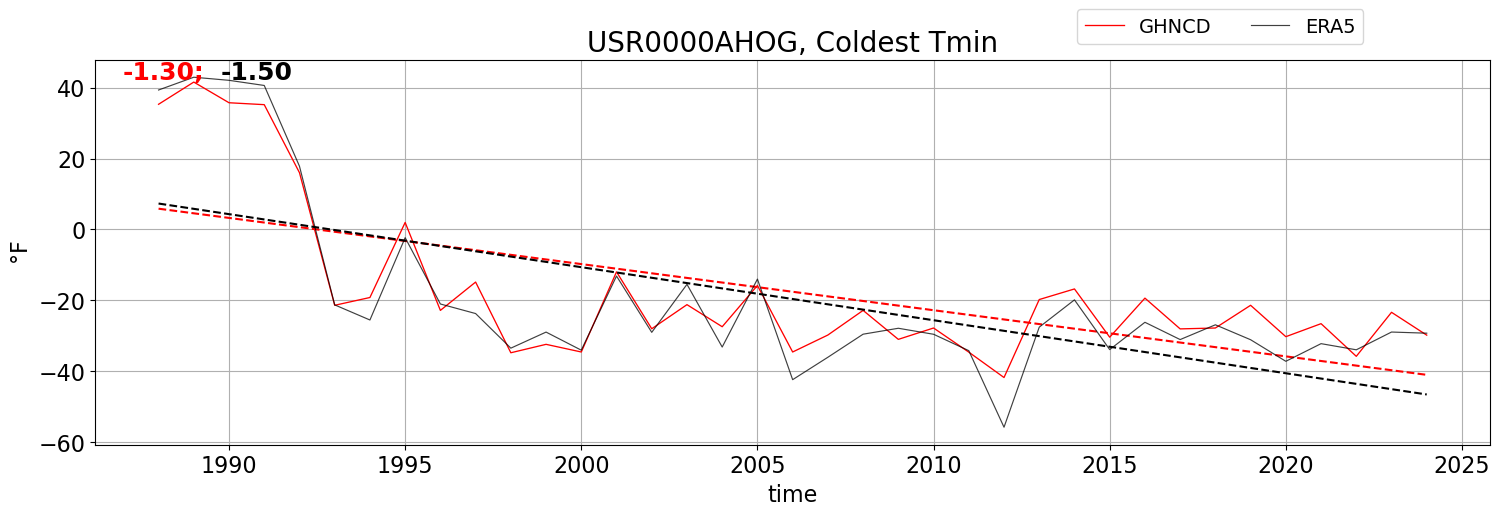

In [141]:
Tip = np.arange(0,len(ds.station),5)
for ip in Tip:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
  #
  ax.plot(Octmin['year'],Octmin.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  aij = Otrend_tmin['polyfit_coefficients'].sel(degree=1).isel(station=ip)
  bij = Otrend_tmin['polyfit_coefficients'].sel(degree=0).isel(station=ip)
  lines=Octmin['year'].where(np.isnan(Octmin.isel(station=ip))==False,drop=True)*aij.values + bij.values
  ax.plot(lines.year,lines,color='r',linestyle='--')
  ax.text(0.02,0.95,f'{aij.values:0.2f};',color='r',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.plot(Octmin['year'],Ectmin.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  aij = Etrend_tmin['polyfit_coefficients'].sel(degree=1).isel(station=ip)
  bij = Etrend_tmin['polyfit_coefficients'].sel(degree=0).isel(station=ip)
  lines=lines.year*aij.values + bij.values
  ax.plot(lines.year,lines,color='k',linestyle='--')
  ax.text(0.09,0.95,f'{aij.values:0.2f}',color='k',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.tick_params(labelsize=16)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  plt.grid()
  plt.ylabel(units,fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'{Tlabel[ip]}, Coldest Tmin',fontsize=20)

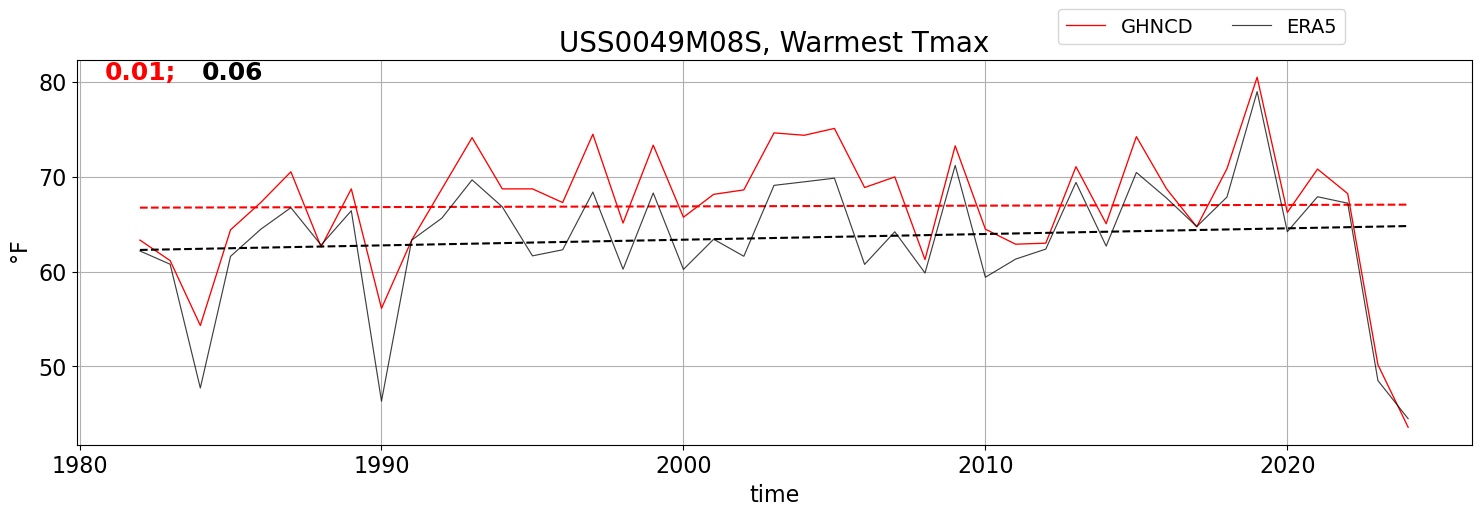

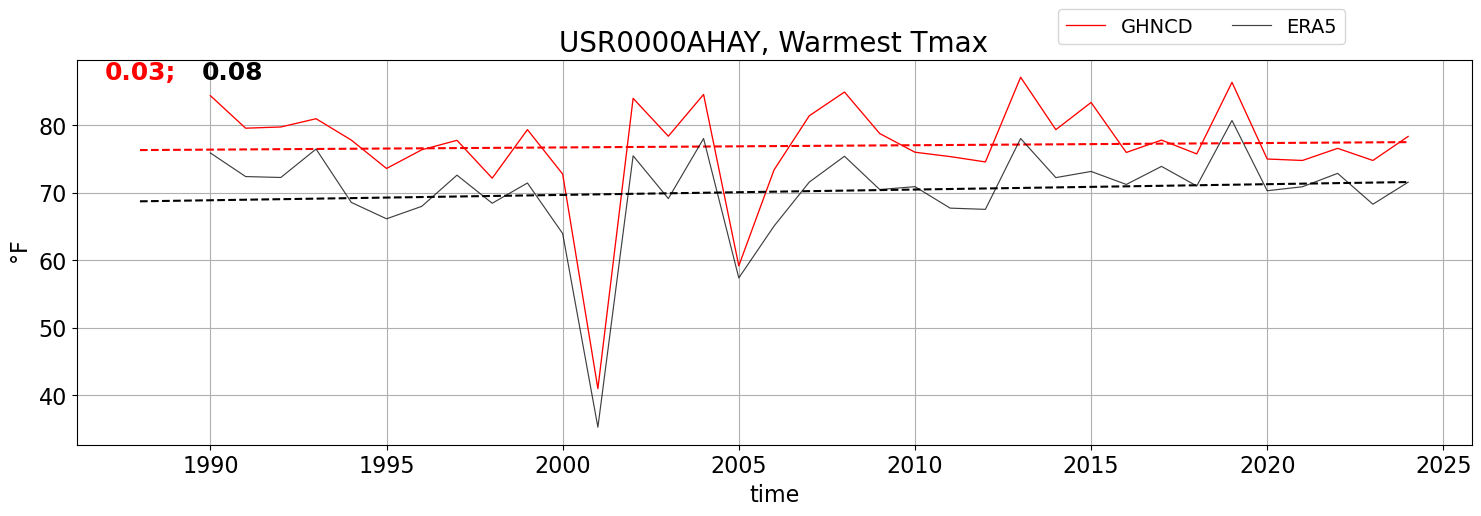

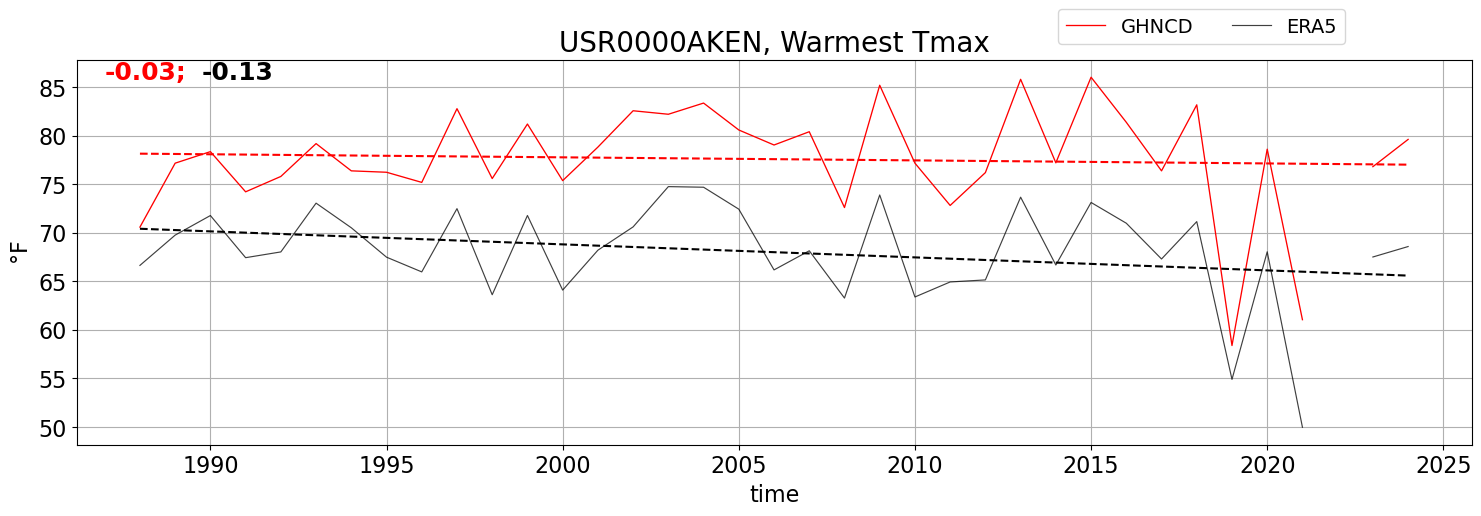

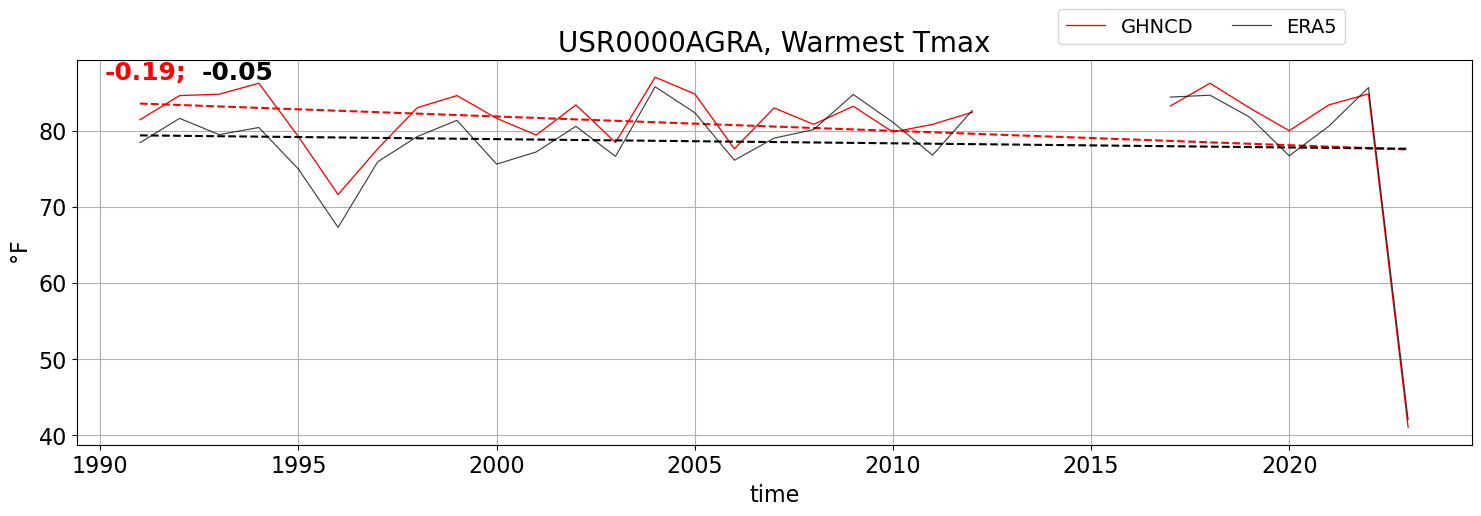

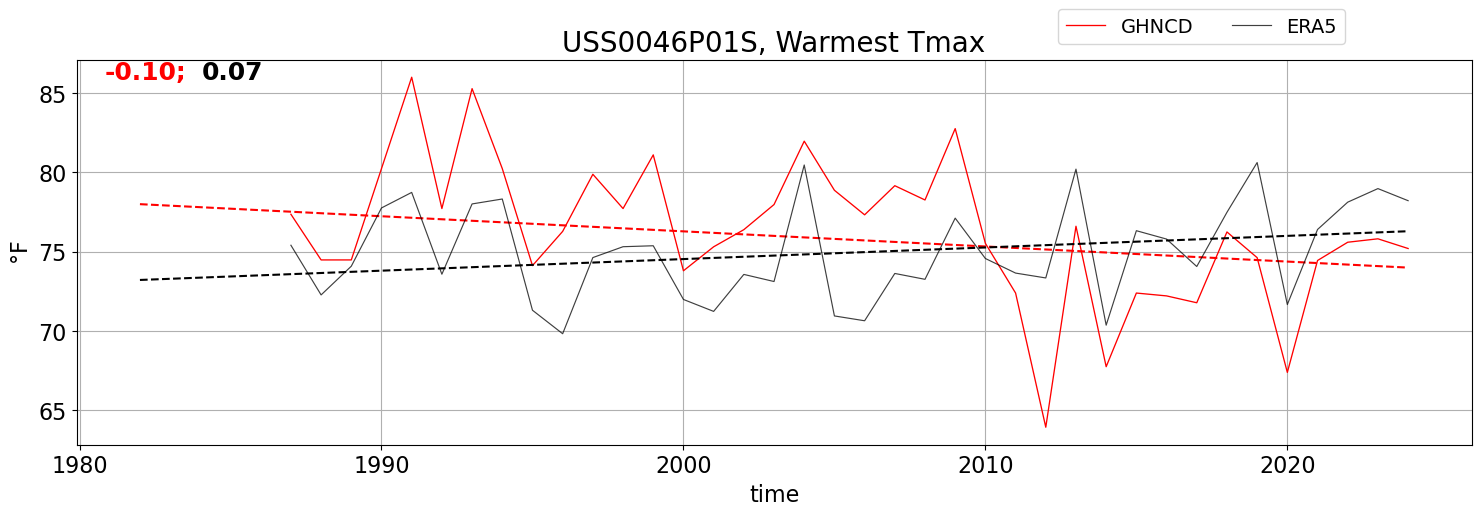

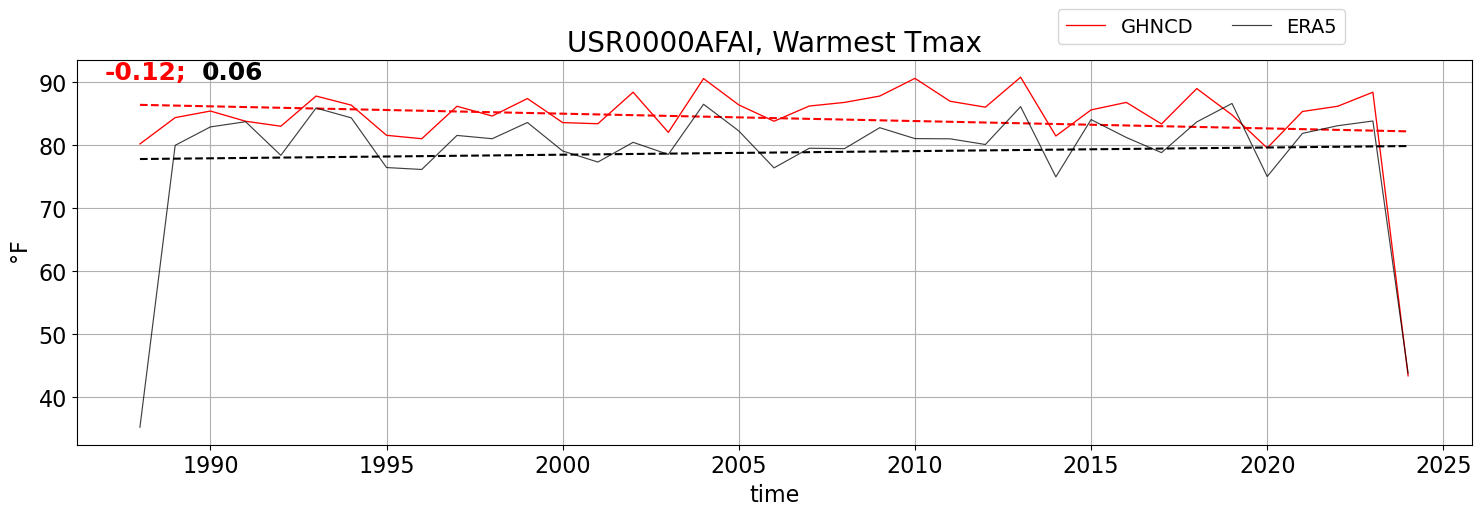

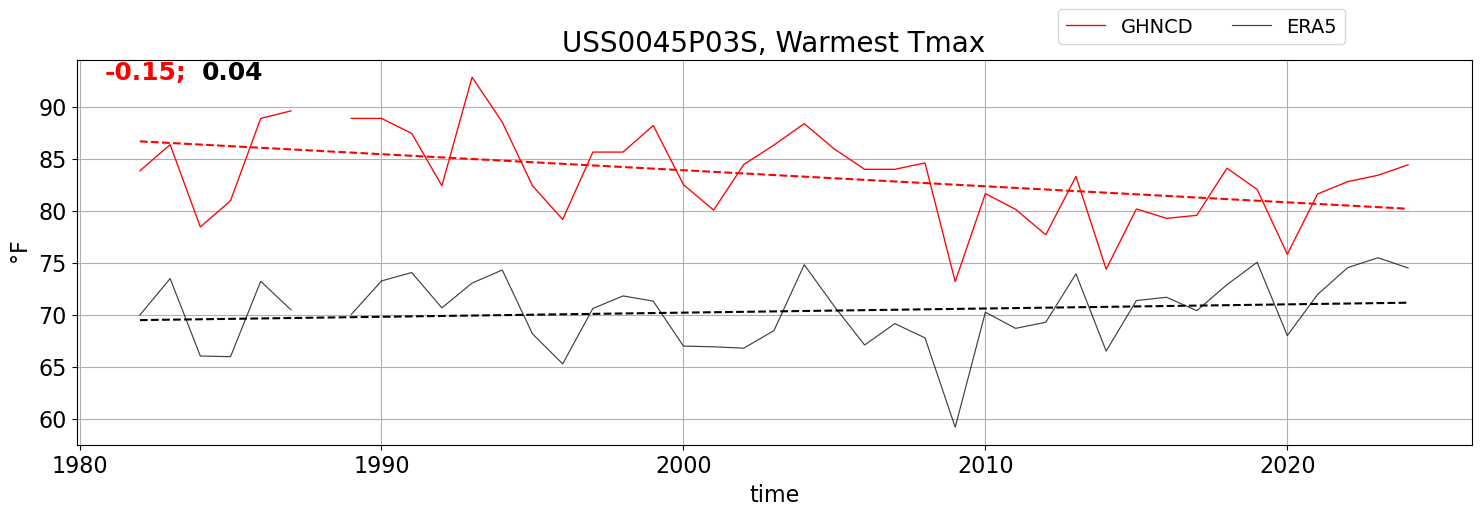

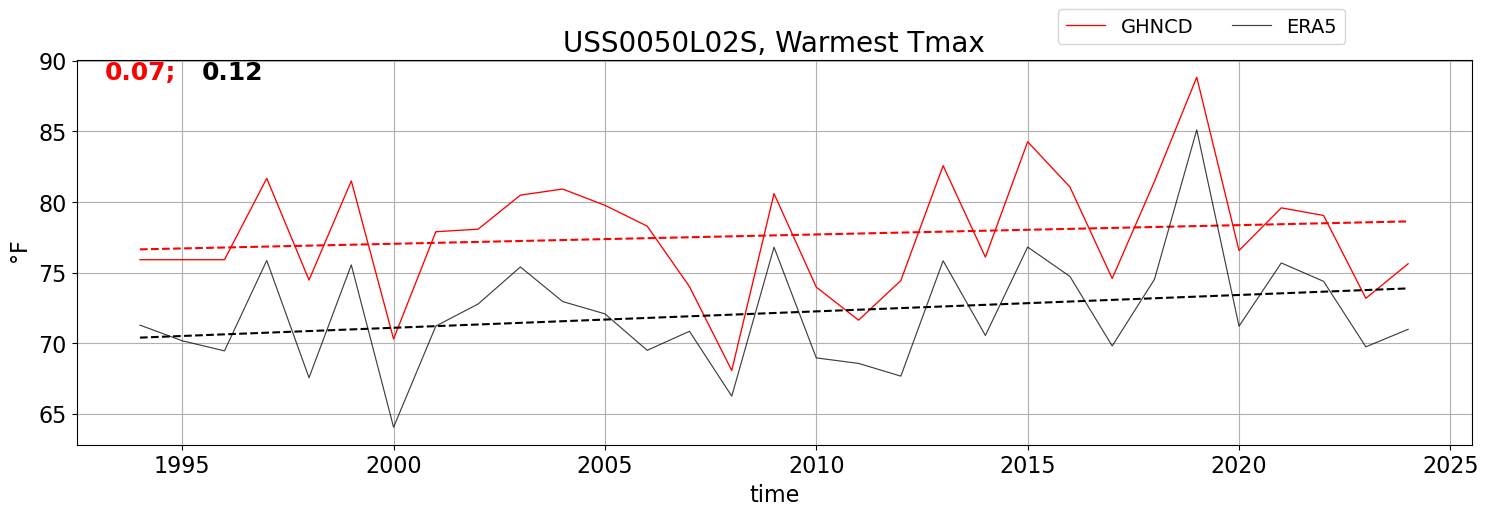

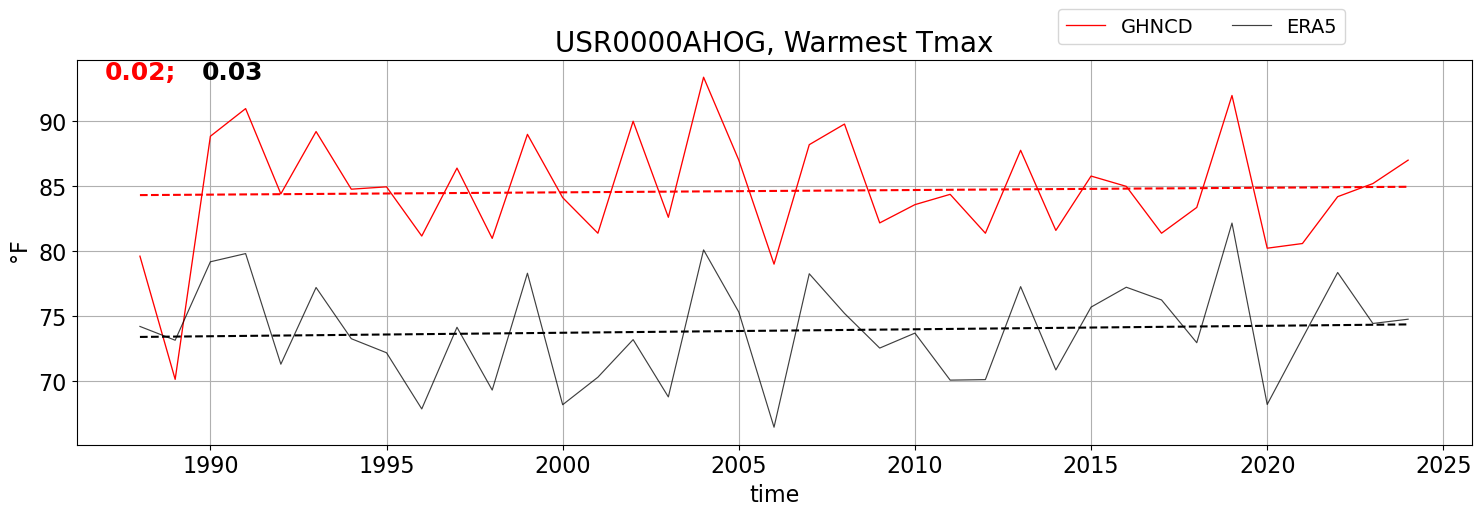

In [142]:
Tip = np.arange(0,len(ds.station),5)
for ip in Tip:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
  #
  ax.plot(Octmax['year'],Octmax.isel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  aij = Otrend_tmax['polyfit_coefficients'].sel(degree=1).isel(station=ip)
  bij = Otrend_tmax['polyfit_coefficients'].sel(degree=0).isel(station=ip)
  lines=Octmax['year'].where(np.isnan(Octmax.isel(station=ip))==False,drop=True)*aij.values + bij.values
  ax.plot(lines.year,lines,color='r',linestyle='--')
  ax.text(0.02,0.95,f'{aij.values:0.2f};',color='r',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.plot(Octmax['year'],Ectmax.isel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  aij = Etrend_tmax['polyfit_coefficients'].sel(degree=1).isel(station=ip)
  bij = Etrend_tmax['polyfit_coefficients'].sel(degree=0).isel(station=ip)
  lines=lines.year*aij.values + bij.values
  ax.plot(lines.year,lines,color='k',linestyle='--')
  ax.text(0.09,0.95,f'{aij.values:0.2f}',color='k',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.tick_params(labelsize=16)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  plt.grid()
  plt.ylabel(units,fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'{Tlabel[ip]}, Warmest Tmax',fontsize=20)

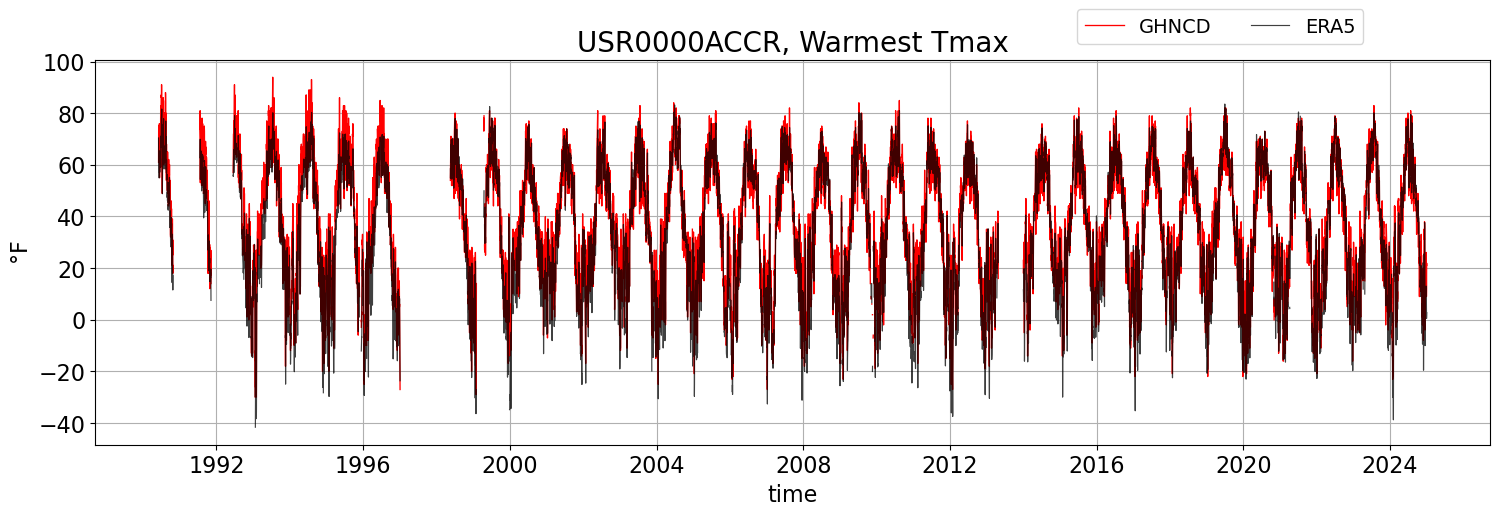

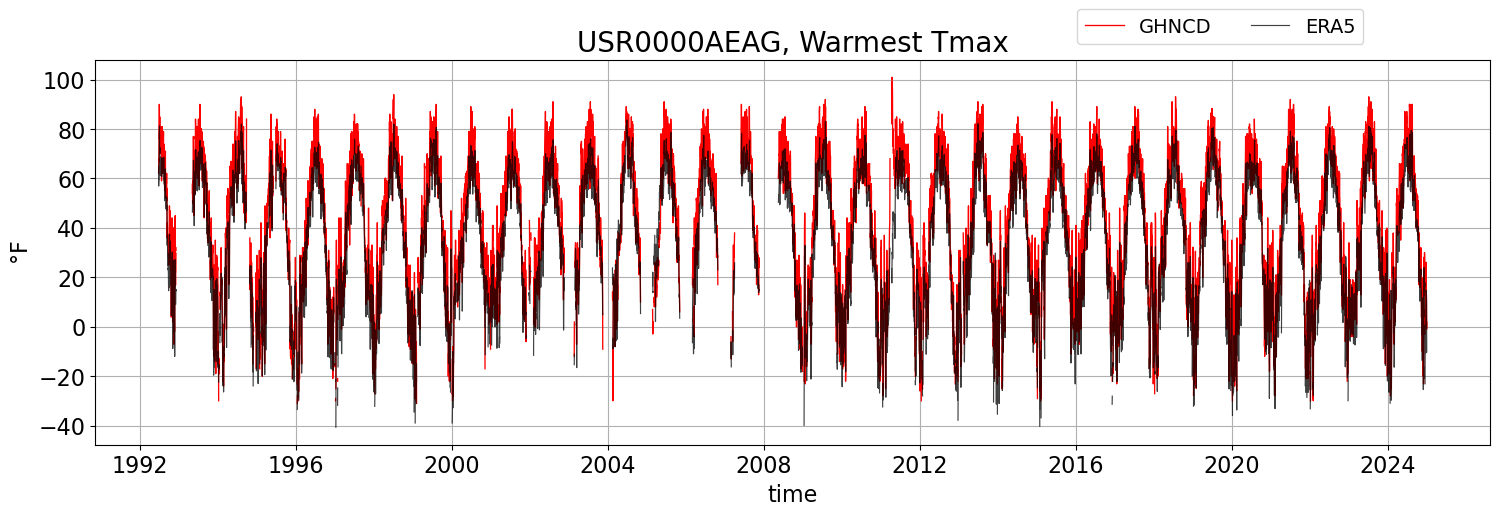

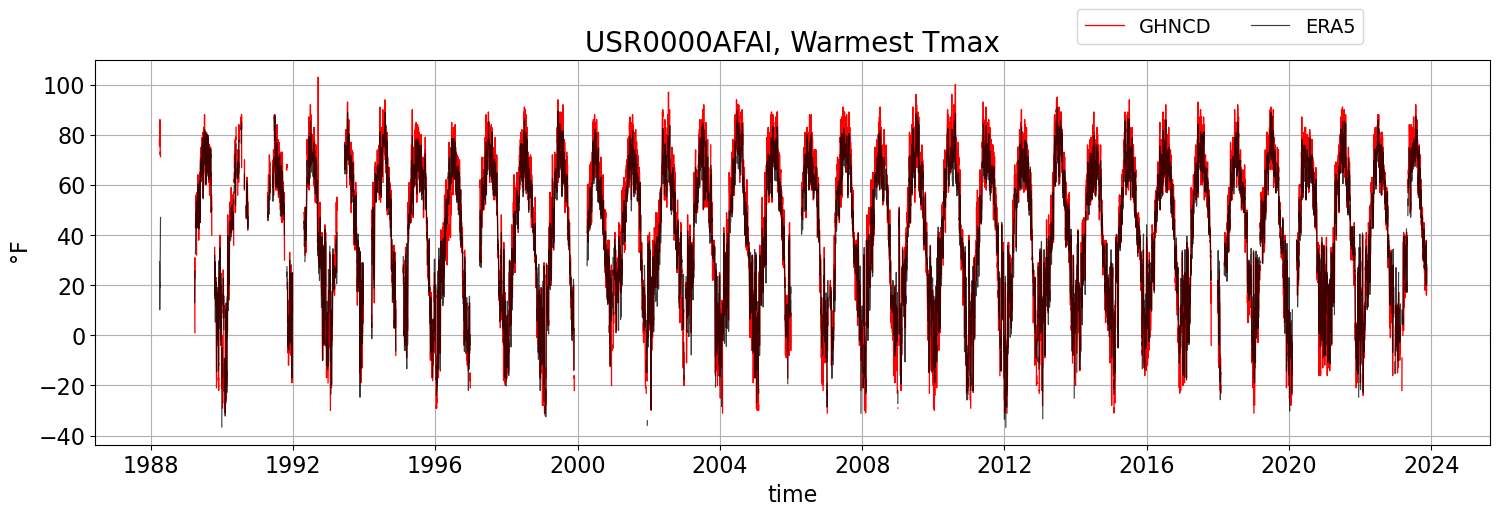

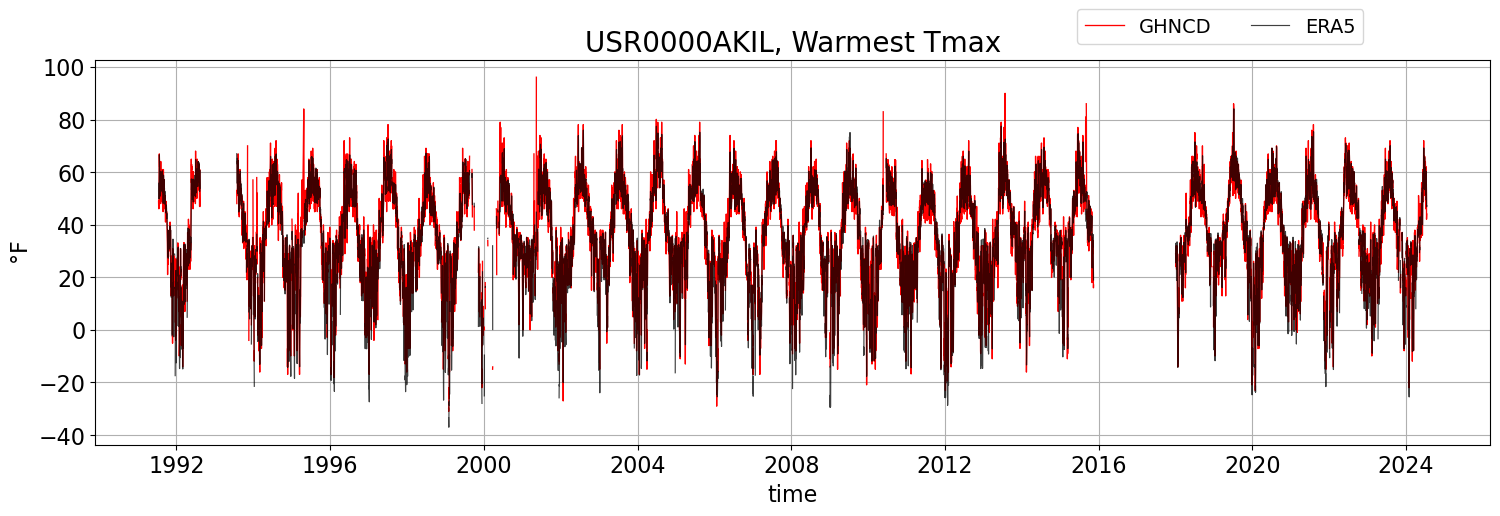

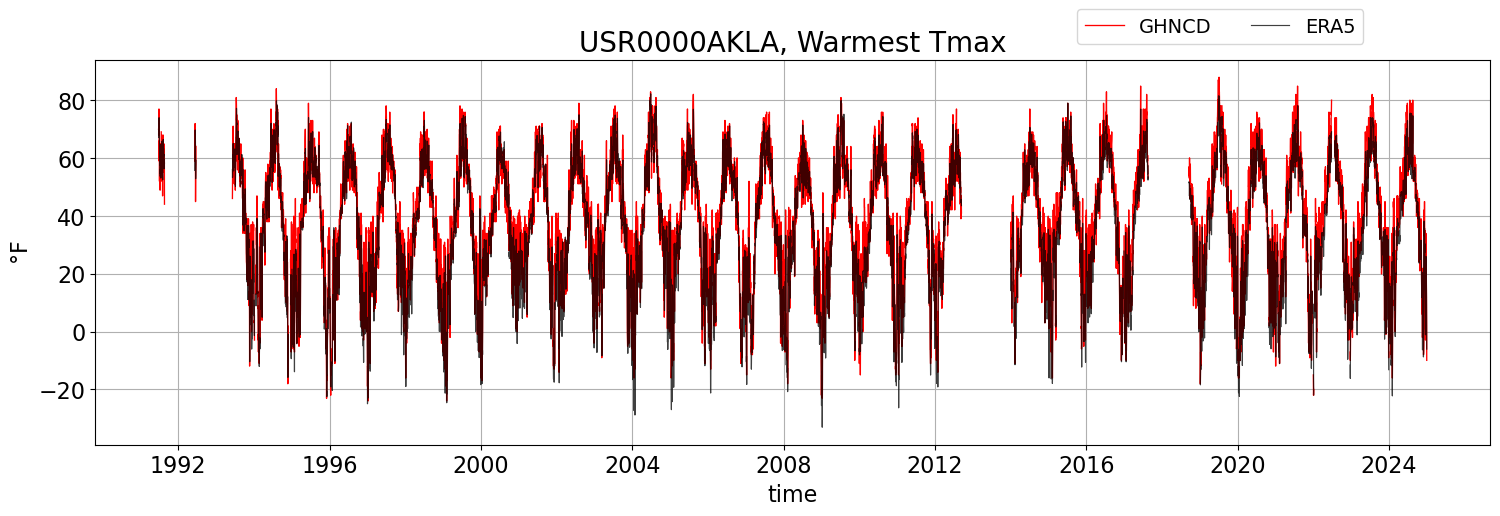

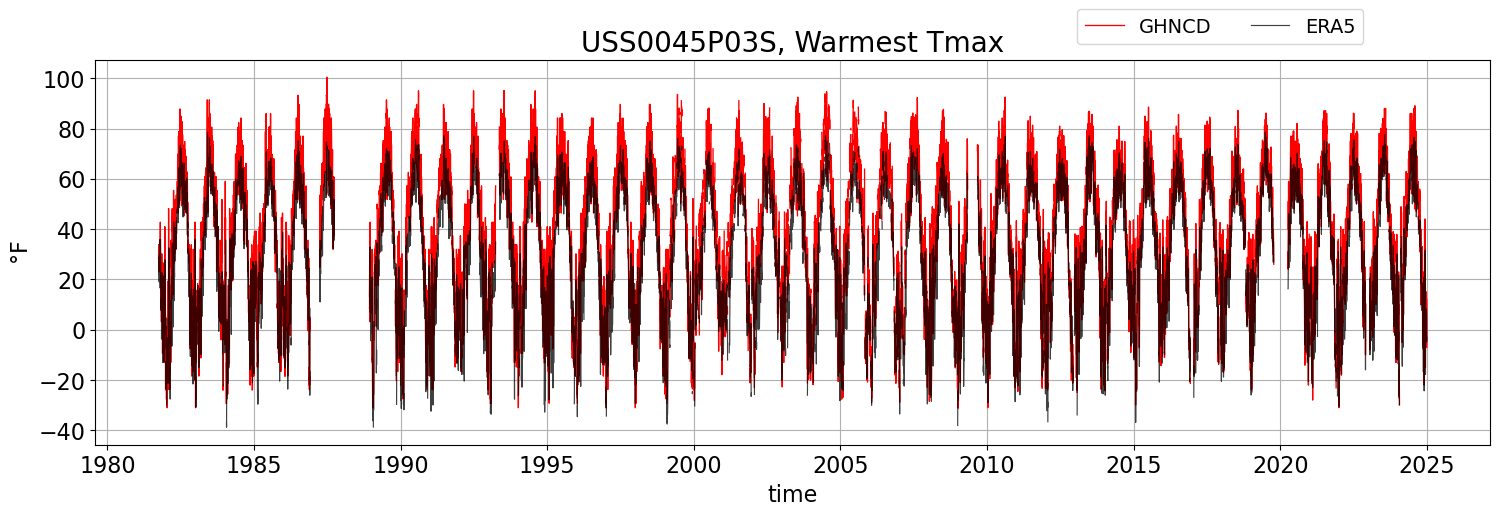

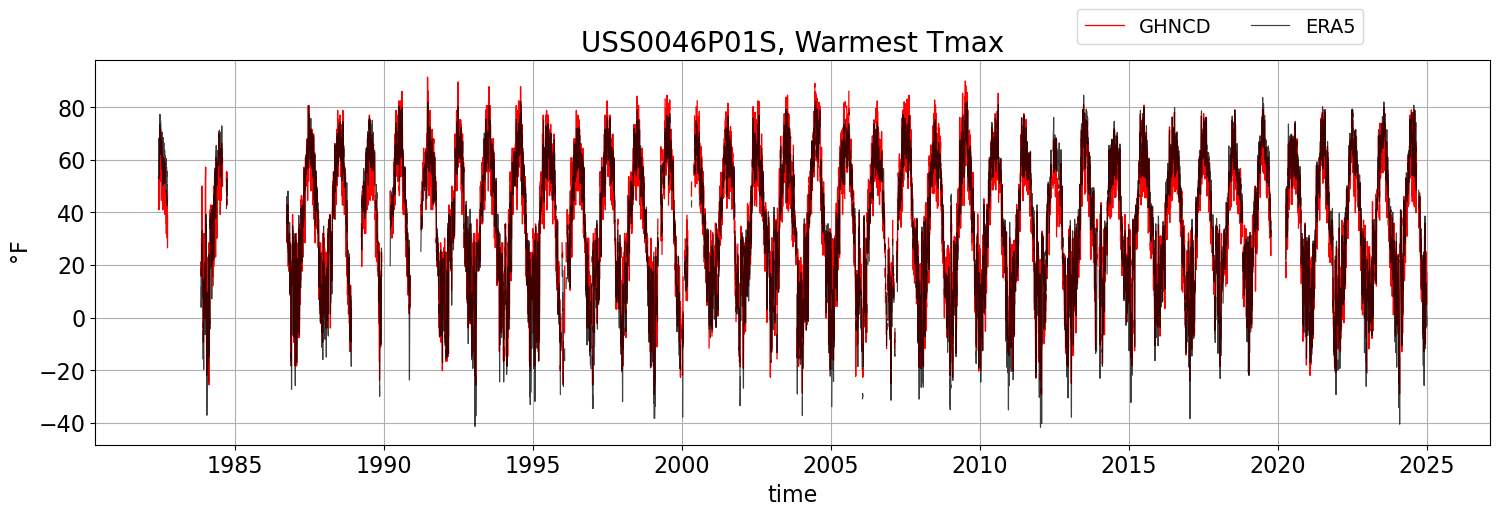

In [143]:
for ip in Tipl:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
  #
  ax.plot(Otmax['time'],Otmax.sel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  ax.plot(Etmax['time'],Etmax.sel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  #
  ax.tick_params(labelsize=16)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  plt.grid()
  plt.ylabel(units,fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'{ip}, Warmest Tmax',fontsize=20)

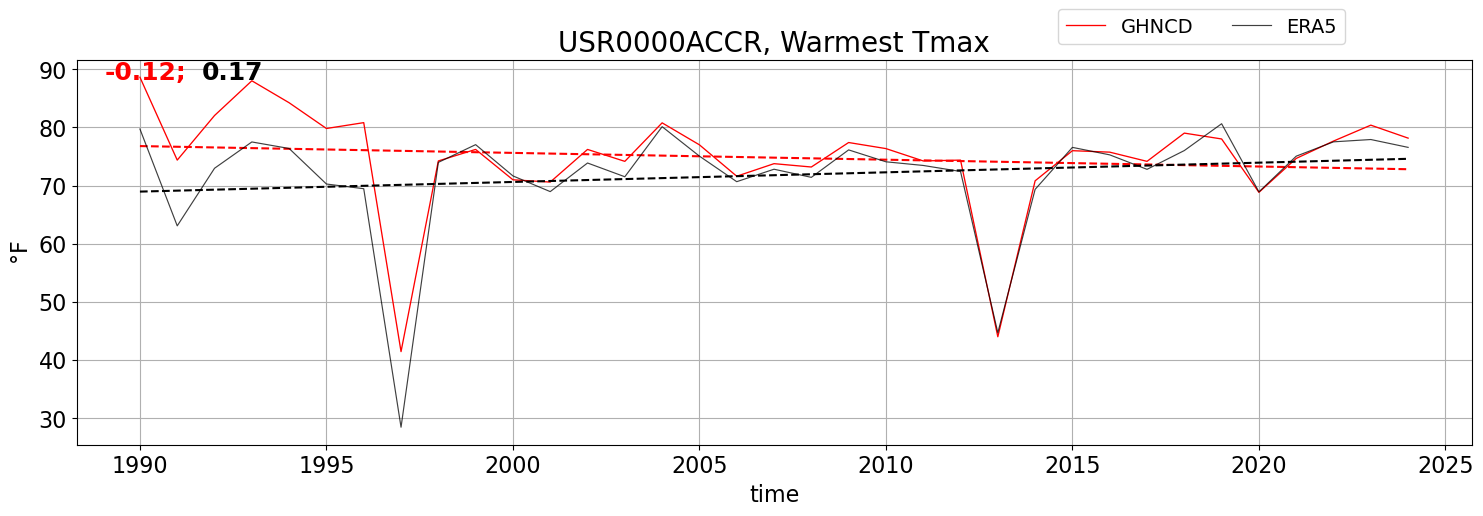

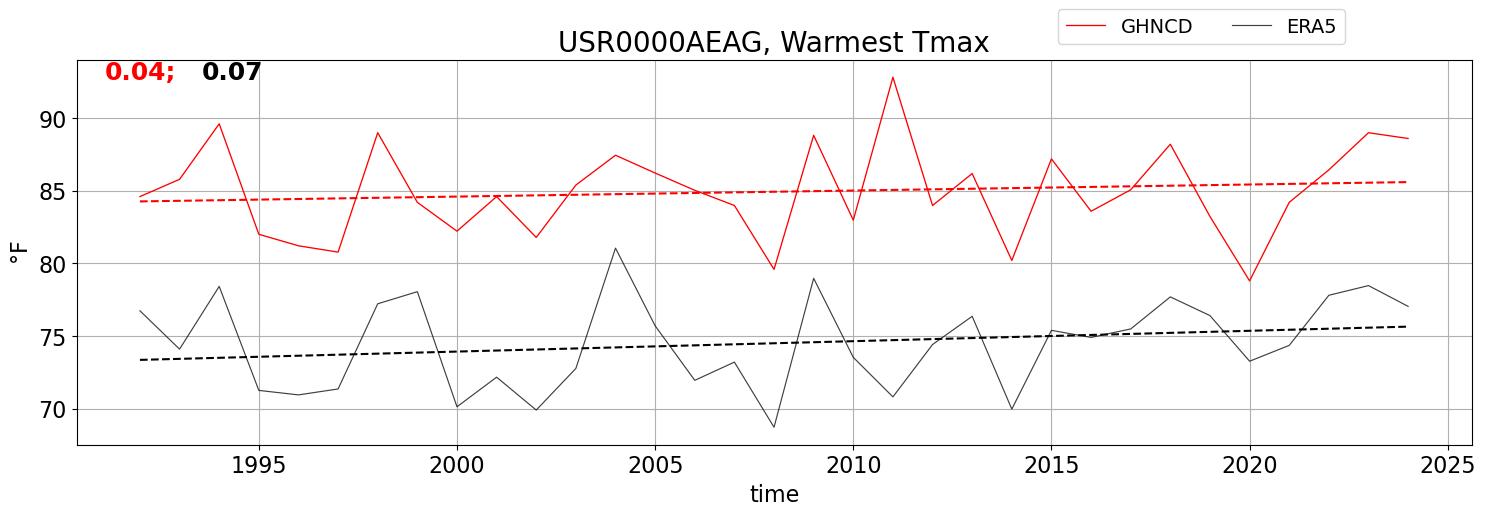

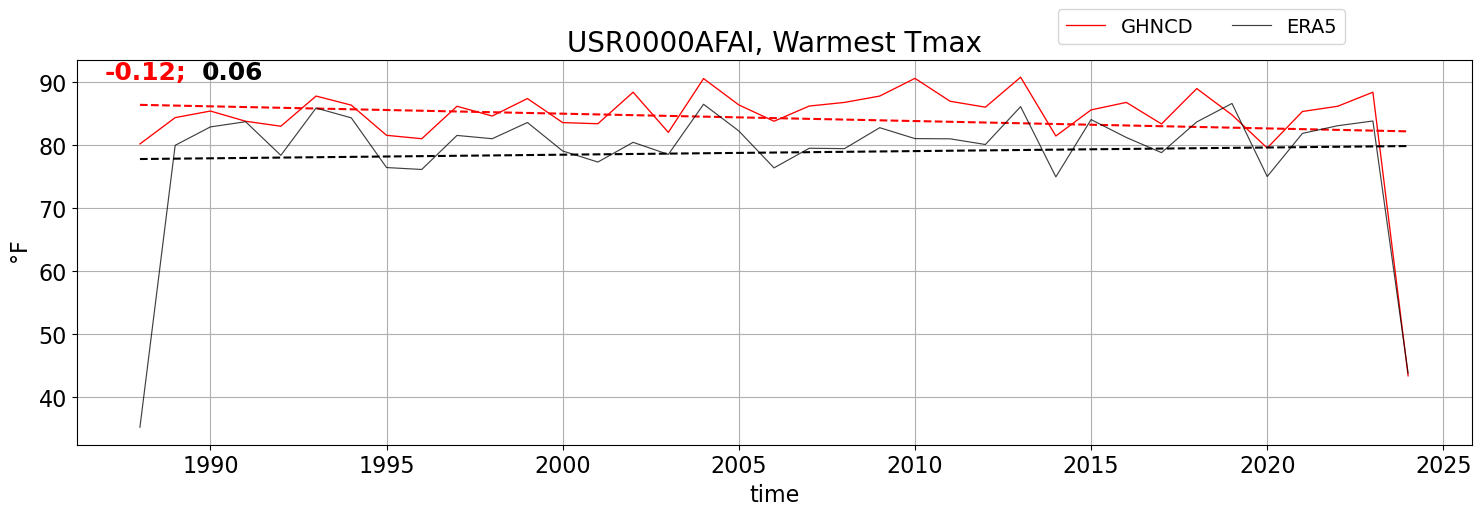

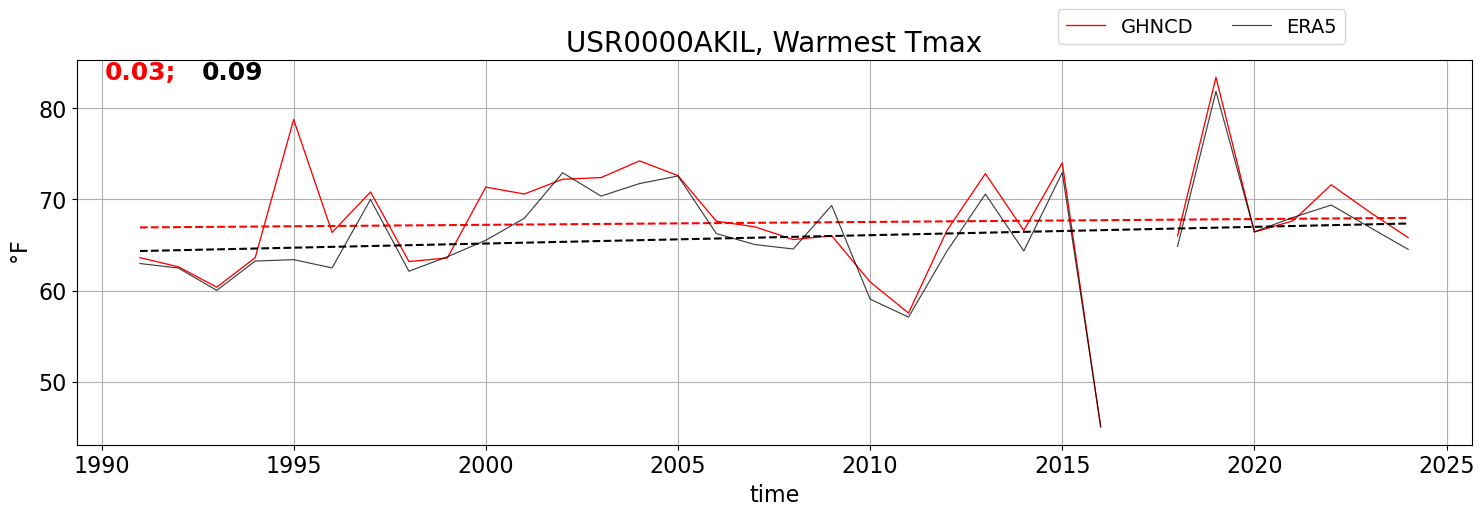

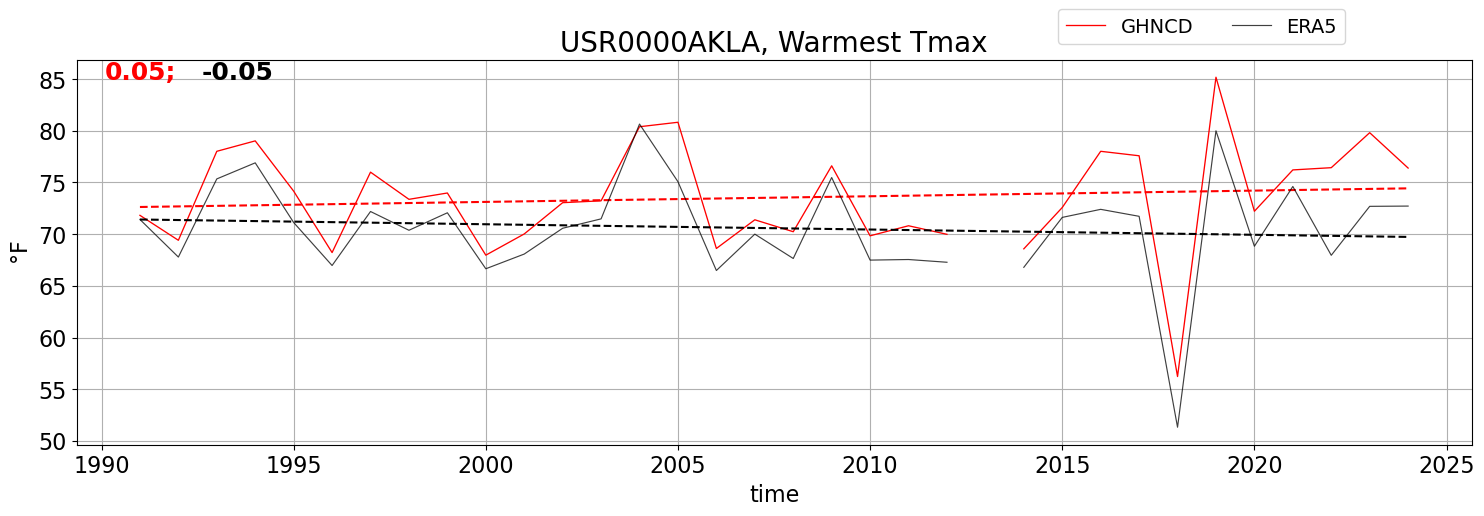

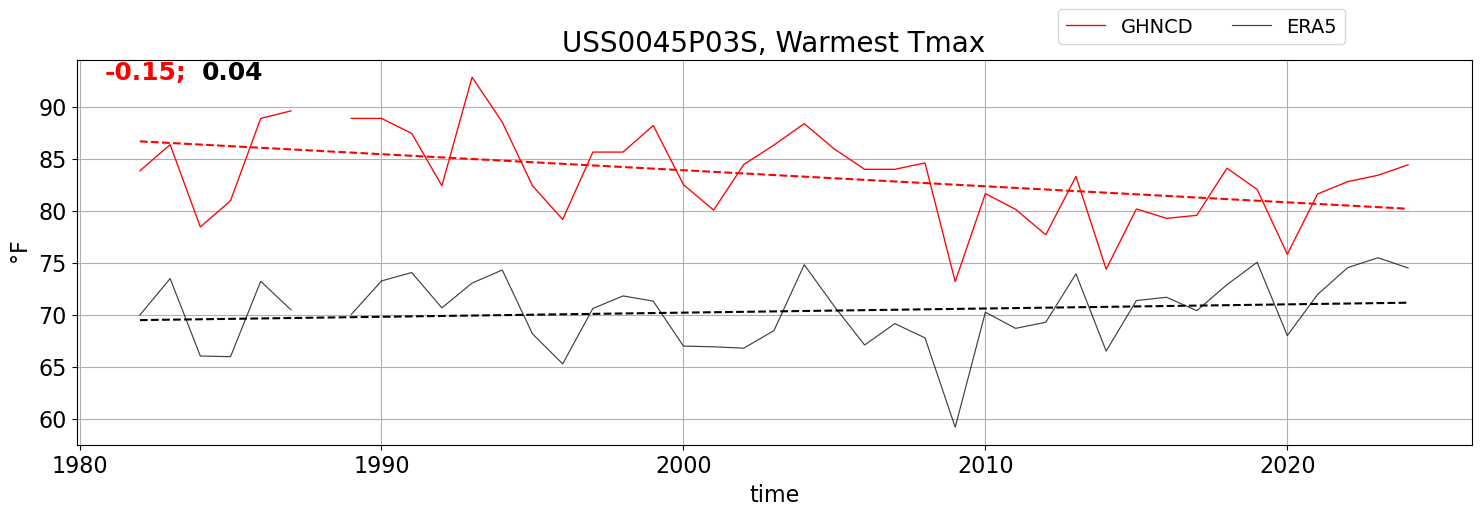

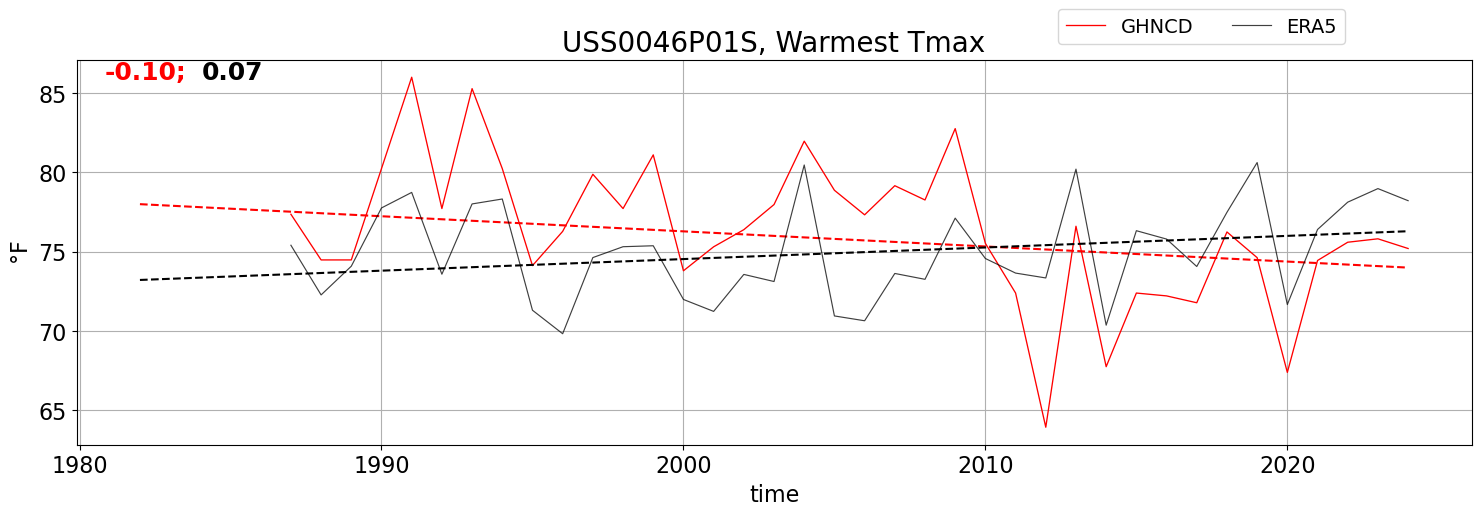

In [144]:
for ip in Tipl:
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
  #
  ax.plot(Octmax['year'],Octmax.sel(station=ip),color='r',linewidth=0.95,label='GHNCD')
  aij = Otrend_tmax['polyfit_coefficients'].sel(degree=1).sel(station=ip)
  bij = Otrend_tmax['polyfit_coefficients'].sel(degree=0).sel(station=ip)
  lines=Octmax['year'].where(np.isnan(Octmax.sel(station=ip))==False,drop=True)*aij.values + bij.values
  ax.plot(lines.year,lines,color='r',linestyle='--')
  ax.text(0.02,0.95,f'{aij.values:0.2f};',color='r',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.plot(Octmax['year'],Ectmax.sel(station=ip),color='k',linewidth=0.85,label='ERA5',alpha=0.75)
  aij = Etrend_tmax['polyfit_coefficients'].sel(degree=1).sel(station=ip)
  bij = Etrend_tmax['polyfit_coefficients'].sel(degree=0).sel(station=ip)
  lines=lines.year*aij.values + bij.values
  ax.plot(lines.year,lines,color='k',linestyle='--')
  ax.text(0.09,0.95,f'{aij.values:0.2f}',color='k',size=18,weight='bold',transform=ax.transAxes)
  #
  ax.tick_params(labelsize=16)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.75,1.0),prop={'size': 14})
  plt.grid()
  plt.ylabel(units,fontsize=16)  
  plt.xlabel('time',fontsize=16)
  plt.title(f'{ip}, Warmest Tmax',fontsize=20)

In [145]:
ip

'USS0046P01S'

Text(0.5, 1.0, 'GHNCD stations - Alaska')

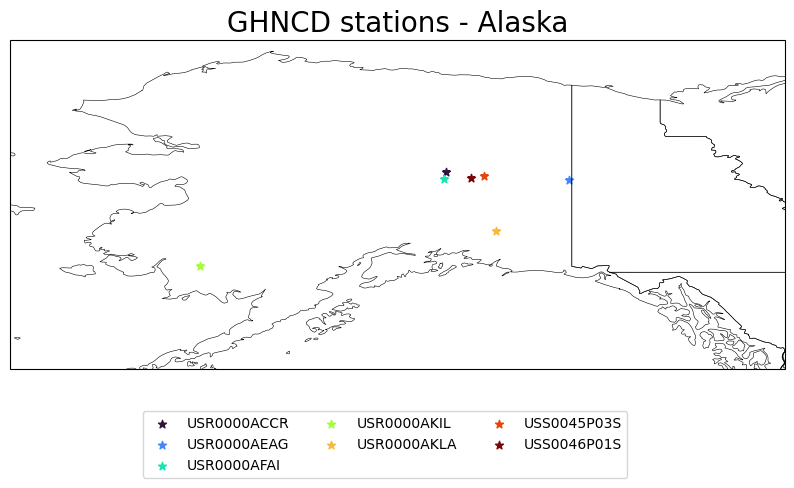

In [146]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(Tipl))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})
k=0
for ip in Tipl:
  #for ip in range(30,40):  
  ax.scatter(ds['longitude'].sel(station=ip),ds['latitude'].sel(station=ip),marker='*',color=colors(k),label=ip)
  k=k+1

ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.24),prop={'size': 10})
ax.set_title('GHNCD stations - Alaska',fontsize=20)